In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
                        #    '--xla_dump_to=xla_dump/')
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from jax_tqdm import scan_tqdm

%load_ext autoreload
%autoreload 2

%env XLA_FLAGS

#jax.devices("gpu")

'--xla_force_host_platform_device_count=10'

In [ ]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### space vs temperature vs subspace dimension with same Path optim

In [3]:
api = wandb.Api()
results = []
# for s_id in ['vl6382k1', 'x26ip745', 'd8bi25u9']:
for s_id in ['sohc5gqt', 'c3gv5slh']:
    t_bar = tqdm(api.sweep(f"ddold/subspace_toy_reg/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config']['prior_scale'],
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       Depth=run.config['curve_params']['model_kwargs']['depth'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                       UniformSSampling=run.config['curve_params']['uniform_t_optimize'],
                       elpd_loo=run.summary.get('elpd_loo', -np.inf),
                       lppd_test=run.summary.get('elpd_test', np.nan),
                       rmse_test=run.summary.get('rmse_test', np.nan),
                       lppd_valid=run.summary.get('elpd_valid', np.nan),
                       rmse_valid=run.summary.get('rmse_valid', np.nan),
                       p_loo=run.summary.get('p_loo', np.inf),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}; state: {run.state}")
df = pd.DataFrame(results)
df

Sweep id: c3gv5slh: 100%|██████████| 2400/2400 [00:07<00:00, 315.85it/s, fallen-sweep-1]          


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,Depth,SubspaceDim,...,rmse_test,lppd_valid,rmse_valid,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,b9lxs97d,mclmc,varphi,1.0,-1.0,-1,316.227766,elu,3,20,...,3.496463,-3.703845,2.440396,inf,10.676659,1.00,1.0000,7158,7665.35,50
1,30706n6d,mclmc,varphi,1.0,-1.0,-1,100.000000,elu,3,20,...,1.546711,-3.278291,0.993652,inf,10.640293,1.00,1.0000,6037,6570.30,50
2,7cxvq5cb,mclmc,varphi,1.0,-1.0,-1,31.622777,elu,3,20,...,0.660945,-2.410574,0.344623,534.056110,13.997868,1.00,1.0000,3859,4691.95,50
3,aszert57,mclmc,varphi,1.0,-1.0,-1,10.000000,elu,3,20,...,0.345202,-0.252571,0.093333,94.903816,13.928669,1.03,1.0160,343,883.55,50
4,xqm5jdjb,mclmc,varphi,1.0,-1.0,-1,3.162278,elu,3,20,...,0.146382,1.259819,0.063232,31.215367,14.190657,1.14,1.0665,50,150.00,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,7lfej3uf,mclmc,lambda,0.5,0.1,25,100.000000,relu,3,2,...,0.091941,-0.029354,0.072979,166.813483,35.885978,1.00,1.0000,9829,9982.00,100
3596,fcfhu5ck,mclmc,lambda,0.5,0.1,25,31.622777,relu,3,2,...,0.058972,0.689234,0.065023,73.517562,35.949899,1.00,1.0000,9943,10008.00,100
3597,py2yrf24,mclmc,lambda,0.5,0.1,25,10.000000,relu,3,2,...,0.051644,1.249221,0.061321,26.518887,33.966570,1.00,1.0000,9520,9634.50,100
3598,2575qa7e,mclmc,lambda,0.5,0.1,25,3.162278,relu,3,2,...,0.057845,1.348282,0.062194,9.719659,33.472742,1.00,1.0000,1978,2646.50,100


In [4]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,Depth,SubspaceDim,...,rmse_test,lppd_valid,rmse_valid,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward


In [5]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
variable_idx = []
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        unique_ = df_clean[c].unique()
        print(c, unique_)
        if (len(unique_) > 1) and (c != 'Seed'):
            variable_idx.append(c)
print(f"\nExperiment differs in {variable_idx} configs")

Unique configuartions: 
Sampler ['mclmc']
Space ['varphi' 'lambda']
PriorScale [1.  0.5]
TubeScale [-1.   0.1]
Epsilon [-1 25]
Temperature [316.22776602 100.          31.6227766   10.           3.16227766
   1.        ]
Activation ['elu' 'relu']
Depth [3]
SubspaceDim [20 10  7  4  2]
Seed [14 13 12 11 10 16 24 23 22 21 20 19 18 17 15]
PriorCorrection ['only t']
SelectFromValidation [ True]
UniformSSampling [False  True]

Experiment differs in ['Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'Activation', 'SubspaceDim', 'UniformSSampling'] configs


In [6]:
variable_idx = np.setdiff1d(variable_idx, ['PriorScale', 'TubeScale', 'Epsilon'])
variable_idx

array(['Activation', 'Space', 'SubspaceDim', 'Temperature',
       'UniformSSampling'], dtype='<U16')

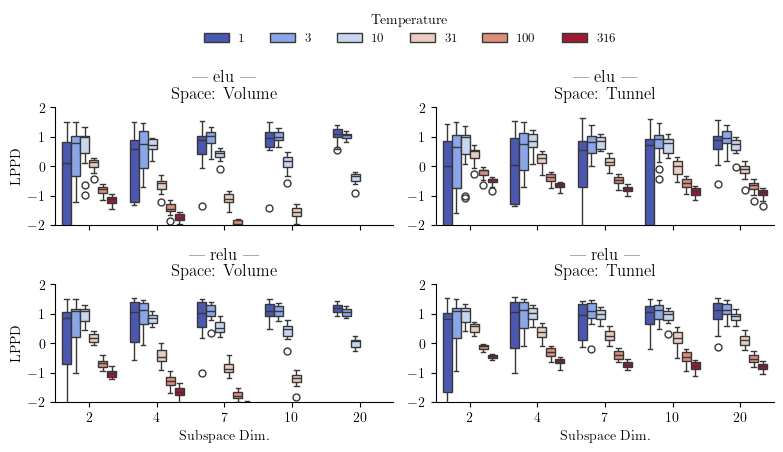

In [36]:
from matplotlib import colors

df_subset = df_clean[(df_clean['Depth'] == 3) & (df_clean['UniformSSampling'] == True)]
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=2, palette='coolwarm', hue_norm=norm)
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
for ax in g.axes.flatten():
    title = ax.get_title()
    new_title = title.replace('lambda', 'Tunnel').replace('varphi', 'Volume')
    ax.set_title(new_title)
# set ylim
for ax in g.axes.flatten():
    ax.set_ylim(-2, 2)
g.axes[1,0].set_xlabel('Subspace Dim.')
g.axes[1,1].set_xlabel('Subspace Dim.')
g.axes[0,0].set_ylabel('LPPD')
g.axes[1,0].set_ylabel('LPPD')
# Update legend labels
for t in g._legend.texts:
    t.set_text(t.get_text().split('.')[0])
g.tight_layout()
sns.move_legend(g, loc='upper center', bbox_to_anchor=(.45, 1.13), ncols=6)
plt.savefig('figures/subspace_toy_reg_all_temp.pdf', bbox_inches='tight')

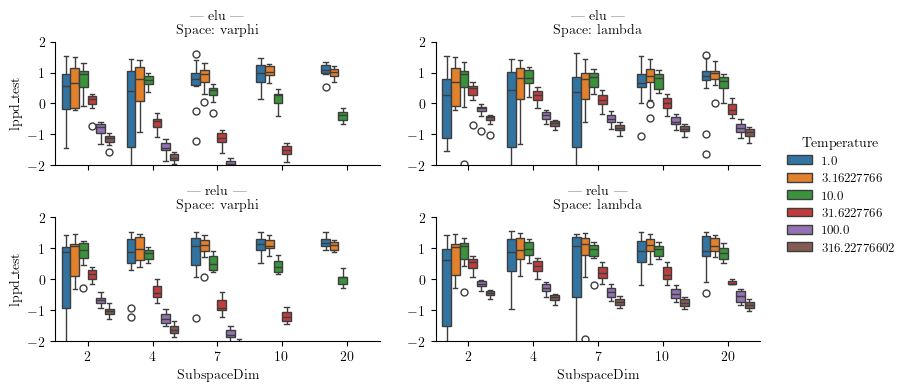

In [13]:
df_subset = df_clean[(df_clean['Depth'] == 3) & (
    df_clean['UniformSSampling'] == False)]
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=2, palette='tab10')
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
g.tight_layout()
# set ylim
for ax in g.axes.flatten():
    ax.set_ylim(-2, 2)

In [22]:
idx_max_lppd_valid = df_clean.groupby(
    ['Depth', 'Activation', 'SubspaceDim', 'Space', 'UniformSSampling', 'Seed'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(['Depth', 'Activation', 'Space', 'SubspaceDim', 'UniformSSampling']).mean()

elpd_loo  lppd_test  \
Depth Activation Space  SubspaceDim UniformSSampling                          
3     elu        lambda 2           False             110.639286  -5.150416   
                                    True              109.806922  -4.248949   
                        4           False             110.148376   0.070964   
                                    True              110.706596  -1.503559   
                        7           False             108.694719  -0.407433   
                                    True              105.997275   0.435043   
                        10          False             107.225623   0.486194   
                                    True                    -inf  -1.664872   
                        20          False                   -inf   0.350169   
                                    True                    -inf   0.800255   
                 varphi 2           False                   -inf  -5.392562   
                                    True              109.183431  -1.830918   
                        4           False             109.685611   0.140276   
                                    True                    -inf  -0.458962   
                        7           False                   -inf   0.410513   
                                    True              106.391806   0.498547   
                        10          False                   -inf   0.869145   
                                    True                    -inf  -2.332447   
                        20          False                   -inf   1.051264   
                                    True                    -inf   1.093280   
      relu       lambda 2           False             112.963240   0.090565   
                                    True              111.014416   0.516720   
                        4           False             107.407990   0.861041   
                                    True              108.278441   0.856765   
                        7           False             106.559559  -0.044661   
                                    True              104.818612   0.902594   
                        10          False             104.838512   0.943655   
                                    True              104.361002   0.979076   
                        20          False              65.056827   0.954444   
                                    True              104.397718   1.044103   
                 varphi 2           False                   -inf  -0.227564   
                                    True                    -inf   0.565076   
                        4           False                   -inf   0.932684   
                                    True                    -inf   0.918769   
                        7           False             105.826486   0.608527   
                                    True              104.022356   0.986981   
                        10          False             105.885539   1.076945   
                                    True                    -inf   1.139901   
                        20          False             101.685459   1.177270   
                                    True                    -inf   1.178783   

                                                      rmse_test  lppd_valid  \
Depth Activation Space  SubspaceDim UniformSSampling                          
3     elu        lambda 2           False              0.240535    1.551020   
                                    True               0.230204    1.539818   
                        4           False              0.191920    1.534275   
                                    True               0.196069    1.538151   
                        7           False              0.202889    1.526138   
                                    True               0.154950    1.528698   
                        10          False              0.152022    1.517653   
                          

In [38]:
df_clean.loc[idx_max_lppd_valid]['Temperature']

1019     1.000000
1005    10.000000
995      1.000000
983      1.000000
970      3.162278
          ...    
1613     1.000000
1601     1.000000
1589     1.000000
1577     1.000000
1565     1.000000
Name: Temperature, Length: 600, dtype: float64

(0.02, 0.07)

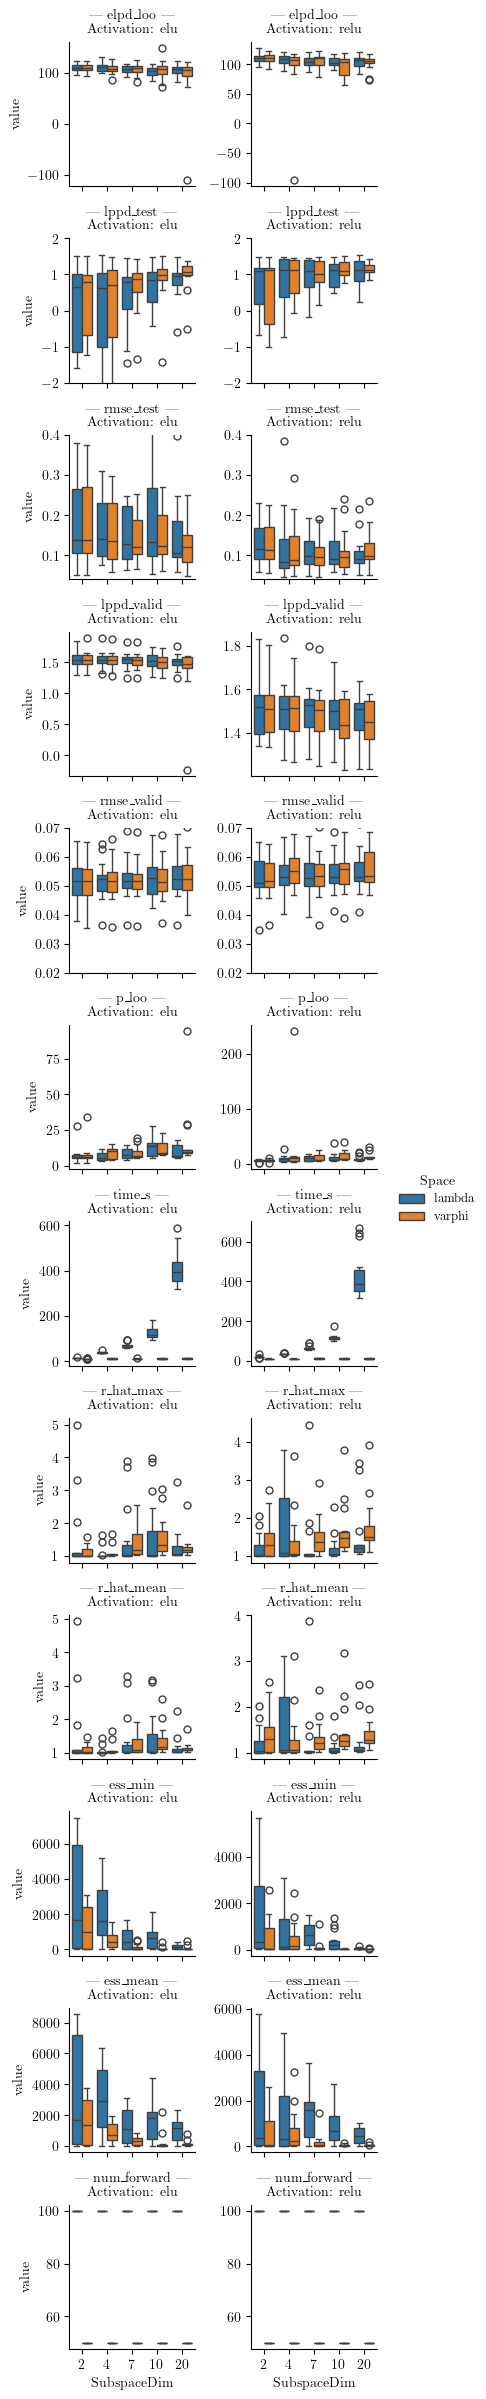

In [15]:
df_subset = df_best_t[(df_best_t['Depth'] == 3) & df_best_t['UniformSSampling'] == True]
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)

g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
                col='Activation', row='metric', kind='box', hue='Space', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nActivation: {col_name}')
g.tight_layout()
g.axes[1, 0].set_ylim(-2, 2)
g.axes[1, 1].set_ylim(-2, 2)
g.axes[2, 0].set_ylim(0.04, 0.4)
g.axes[2, 1].set_ylim(0.04, 0.4)
g.axes[4, 0].set_ylim(0.02, 0.07)
g.axes[4, 1].set_ylim(0.02, 0.07)

(0.0, 2.0)

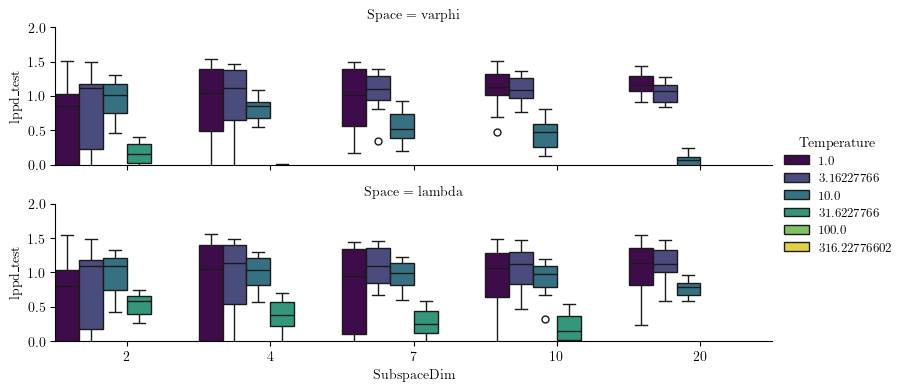

In [16]:
from matplotlib import colors
df_subset = df_clean[(df_clean['Activation'] == 'relu')
                     & (df_clean['Depth'] == 3)
                     & (df_clean['UniformSSampling'] == True)]
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                row='Space', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))
g.axes[0, 0].set_ylim(0,2)
g.axes[1, 0].set_ylim(0,2)
# g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

(-1.0, 3.1799256801605225)

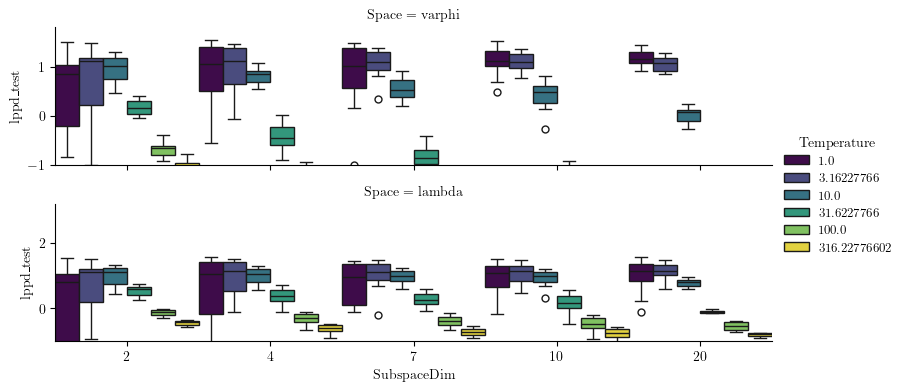

In [17]:
from matplotlib import colors
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                row='Space', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))
g.axes[0, 0].set_ylim(-1, )
g.axes[1, 0].set_ylim(-1, )
# g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

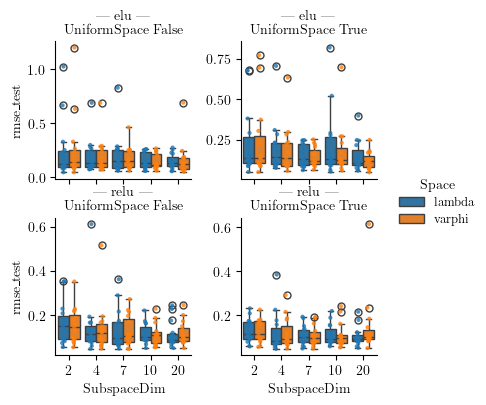

In [18]:
df_subset = df_best_t[(df_best_t['Depth'] == 3)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='UniformSSampling', row='Activation', kind='box', hue='Space', sharey=False, height=figsize[1])

g.map_dataframe(sns.stripplot, y='rmse_test', x='SubspaceDim',
                hue='Space', palette='tab10', dodge=True, alpha=0.8, linewidth=0, s=3)
g.set_titles(row_template='--- {row_name}',
             col_template="\n UniformSpace {col_name}")
            #  col_template=f"\nPath optim: {'U~(0,S)' if col_name else 'U~(0,1)'}")
# g.axes[1, 0].set_ylim(-2, 2)
# g.axes[1, 1].set_ylim(-2, 2)
# g.axes[0, 0].set_ylim(0.04, 0.4)
# g.axes[0, 1].set_ylim(0.04, 0.4)
# g.axes[0, 0].set_ylim(0.02, 0.07)
# g.axes[0, 1].set_ylim(0.02, 0.07)
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

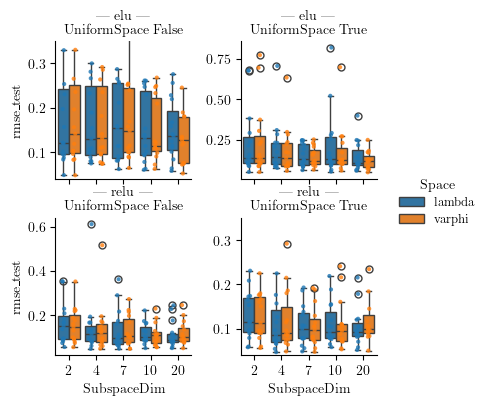

In [19]:
# df_subset = df_best_t[(df_best_t['Activation'] == 'elu')]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='UniformSSampling',row='Activation', kind='box', hue='Space', sharey=False, height=figsize[1])
g.map_dataframe(sns.stripplot, y='rmse_test', x='SubspaceDim',
                hue='Space', palette='tab10', dodge=True, alpha=0.8, linewidth=0, s=3)
g.set_titles(row_template='--- {row_name}',
             col_template="\n UniformSpace {col_name}")
# g.axes[1, 0].set_ylim(-2, 2)
# g.axes[1, 1].set_ylim(-2, 2)
g.axes[0, 0].set_ylim(0.04, 0.35)
g.axes[0, 0].set_ylim(0.04, 0.35)
g.axes[1, 1].set_ylim(0.04, 0.35)
g.axes[1, 1].set_ylim(0.04, 0.35)
# g.axes[0, 2].set_ylim(0.04, 0.4)
# g.axes[0, 0].set_ylim(0.02, 0.07)
# g.axes[0, 1].set_ylim(0.02, 0.07)
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

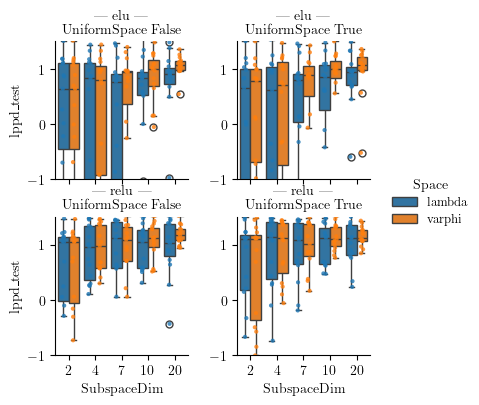

In [20]:
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='UniformSSampling', row='Activation', kind='box', hue='Space', sharey=False, height=figsize[1])
g.map_dataframe(sns.stripplot, y='lppd_test', x='SubspaceDim',
                hue='Space', palette='tab10', dodge=True, alpha=0.8, linewidth=0, s=3)
g.set_titles(row_template='--- {row_name}',
             col_template="\n UniformSpace {col_name}")
g.axes[0, 0].set_ylim(-1., 1.5)
g.axes[0, 1].set_ylim(-1., 1.5)
g.axes[1, 0].set_ylim(-1., 1.5)
g.axes[1, 1].set_ylim(-1., 1.5)
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

(0.04, 0.35)

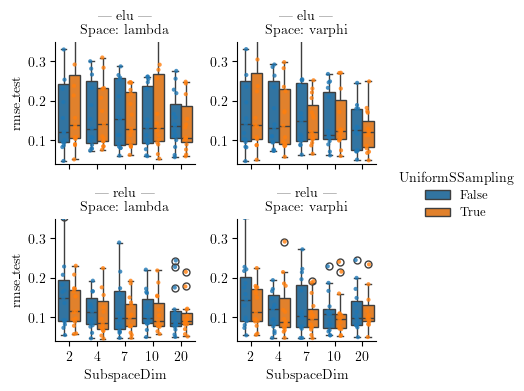

In [21]:
df_subset = df_best_t[(df_best_t['Depth'] == 3)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='UniformSSampling', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
g.map_dataframe(sns.stripplot, y='rmse_test', x='SubspaceDim',
                hue='UniformSSampling', palette='tab10', dodge=True, alpha=0.8, linewidth=0, s=3)

g.axes[0, 0].set_ylim(0.04, 0.35)
g.axes[0, 1].set_ylim(0.04, 0.35)
g.axes[1, 0].set_ylim(0.04, 0.35)
g.axes[1, 1].set_ylim(0.04, 0.35)
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

(-2.0, 2.0)

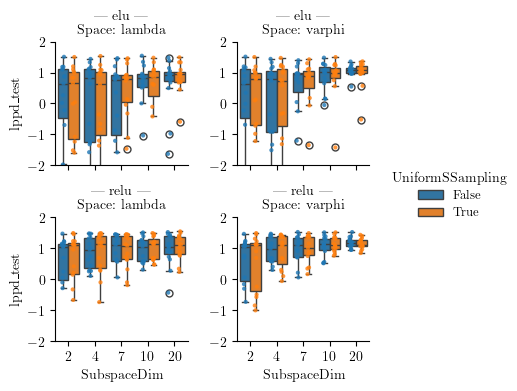

In [22]:
df_subset = df_best_t[(df_best_t['Depth'] == 3)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='UniformSSampling', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
g.map_dataframe(sns.stripplot, y='lppd_test', x='SubspaceDim',
                hue='UniformSSampling', palette='tab10', dodge=True, alpha=0.8, linewidth=0, s=3)

g.axes[0, 0].set_ylim(-2., 2.)
g.axes[0, 1].set_ylim(-2., 2.)
g.axes[1, 0].set_ylim(-2., 2.)
g.axes[1, 1].set_ylim(-2., 2.)

In [40]:
np.unique(df_clean['Temperature'])

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        , 316.22776602])

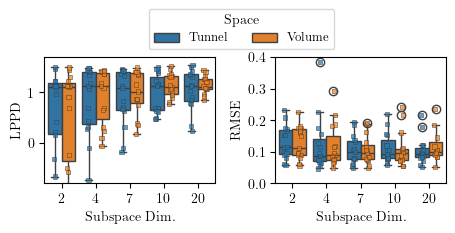

In [73]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu') & (
    df_best_t['Depth'] == 3) & (df_best_t['UniformSSampling'] == True)]

# df_subset = df_clean[(df_clean['Activation'] == 'relu')
#                      & (df_clean['Depth'] == 3)
#                     #  & (df_clean['Temperature'] == 1)
#                     #  & (df_clean['Temperature'] == 10)  # large drop in volume performance
#                      & (df_clean['Temperature'] == 3.16227766)
#                      & (df_clean['UniformSSampling'] == True)]
hue_order = ['lambda', 'varphi']
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.boxplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue_order=hue_order,
              hue='Space', ax=ax[0], legend=False)
sns.stripplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[0], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)
ax[0].set_ylim(-.8, 1.7)
ax[0].set_ylabel('LPPD')
sns.boxplot(data=df_subset, y='rmse_test',
              x='SubspaceDim', hue_order=hue_order, hue='Space', ax=ax[1])
sns.stripplot(data=df_subset, y='rmse_test', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[1], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)
ax[1].set_ylim(0., .4)
ax[1].set_ylabel('RMSE')
plt.tight_layout()
# ax[1].legend(loc='upper center', title='Space', bbox_to_anchor=(-.2, 1.45), ncols=2)
ax[0].set_xlabel('Subspace Dim.')
ax[1].set_xlabel('Subspace Dim.')
handlers, labels = ax[1].get_legend_handles_labels()
labels = ["Tunnel" if l == 'lambda' else 'Volume' for l in labels]
ax[1].get_legend().remove()
fig.legend(handlers, labels, loc='upper center',
           title='Space', bbox_to_anchor=(.55, 1.17), ncol=2)

fig.savefig('figures/reg_best_t_lppd_test_clean.pdf', bbox_inches='tight')

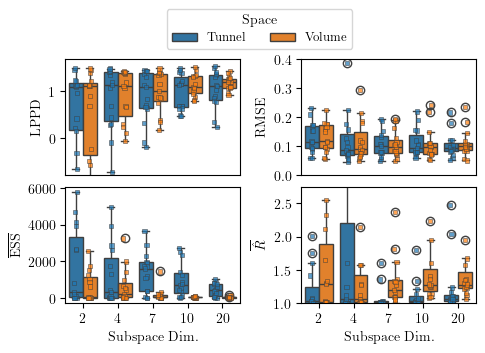

In [25]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu') & (
    df_best_t['Depth'] == 3) & (df_best_t['UniformSSampling'] == True)]

# df_subset = df_clean[(df_clean['Activation'] == 'relu')
#                      & (df_clean['Depth'] == 3)
#                     #  & (df_clean['Temperature'] == 1)
#                     #  & (df_clean['Temperature'] == 10)  # large drop in volume performance
#                      & (df_clean['Temperature'] == 3.16227766)
#                      & (df_clean['UniformSSampling'] == True)]
hue_order = ['lambda', 'varphi']
fig, ax = plt.subplots(2, 2, figsize=(figsize[0]*1.5, figsize[1]*1.5))
# df_subset = df_best_t
sns.boxplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue_order=hue_order,
            hue='Space', ax=ax[0,0], legend=False)
sns.stripplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[0,0], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)
ax[0,0].set_ylim(-.8, 1.7)
ax[0,0].set_ylabel('LPPD')
sns.boxplot(data=df_subset, y='rmse_test',
            x='SubspaceDim', hue_order=hue_order, hue='Space', ax=ax[0,1])
sns.stripplot(data=df_subset, y='rmse_test', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[0,1], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)
ax[0,1].set_ylim(0., .4)
ax[0,1].set_ylabel('RMSE')
plt.tight_layout()
# ax[0,1].legend(loc='upper center', title='Space', bbox_to_anchor=(-.2, 1.45), ncols=2)
# ax[0,0].set_xlabel('Subspace Dim.')
# ax[0,1].set_xlabel('Subspace Dim.')
ax[0,0].get_xaxis().set_visible(False)
ax[0,1].get_xaxis().set_visible(False)
handlers, labels = ax[0,1].get_legend_handles_labels()
labels = ["Tunnel" if l == 'lambda' else 'Volume' for l in labels]
ax[0,1].get_legend().remove()
fig.legend(handlers, labels, loc='upper center',
           title='Space', bbox_to_anchor=(.5, 1.12), ncol=2)


sns.boxplot(data=df_subset, y='ess_mean', x='SubspaceDim', hue_order=hue_order,
            hue='Space', ax=ax[1,0], legend=False)
sns.stripplot(data=df_subset, y='ess_mean', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[1,0], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)
# ax[1,0].set_ylim(0., 4000)
ax[1,0].set_ylabel(r'$\overline{\textrm{ESS}}$')
sns.boxplot(data=df_subset, y='r_hat_mean',
            x='SubspaceDim', hue_order=hue_order, hue='Space', ax=ax[1,1], legend=False)
sns.stripplot(data=df_subset, y='r_hat_mean', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[1,1], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)

ax[1,1].set_ylim(1., 2.75)
ax[1,1].set_ylabel(r'$\overline{\hat{R}}$')

ax[1,0].set_xlabel('Subspace Dim.')
ax[1,1].set_xlabel('Subspace Dim.')
fig.subplots_adjust(hspace=0.1, wspace=0.35)

fig.savefig('figures/reg_best_t_metrics_clean.pdf', bbox_inches='tight')

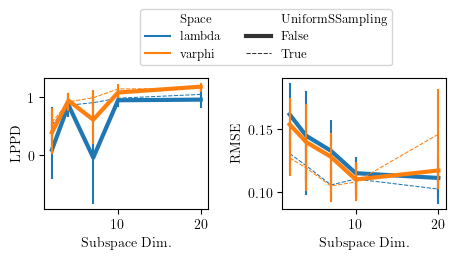

In [24]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu') & (
    df_best_t['Depth'] == 3)]
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.lineplot(data=df_subset, y='lppd_test', x='SubspaceDim',
              hue='Space', style='UniformSSampling',size='UniformSSampling', ax=ax[0], errorbar='se', legend=False, err_style='bars')
# ax[0].set_ylim(0., 1.5)
ax[0].set_ylabel('LPPD')
sns.lineplot(data=df_subset, y='rmse_test',
              x='SubspaceDim', style='UniformSSampling',size='UniformSSampling', hue='Space', errorbar='se', ax=ax[1], err_style='bars')
# ax[1].set_ylim(0., .4)
ax[1].set_ylabel('RMSE')
plt.tight_layout()
# ax[1].legend(loc='upper center', title='Space', bbox_to_anchor=(-.2, 1.45), ncols=2)
ax[0].set_xlabel('Subspace Dim.')
ax[1].set_xlabel('Subspace Dim.')
handlers, labels = ax[1].get_legend_handles_labels()
# labels = ["Tunnel" if l == 'lambda' else 'Volume' for l in labels]
ax[1].get_legend().remove()
fig.legend(handlers, labels, loc='upper center', bbox_to_anchor=(.6, 1.3), ncol=2)

# fig.savefig('figures/reg_best_t_lppd_test.pdf', bbox_inches='tight')

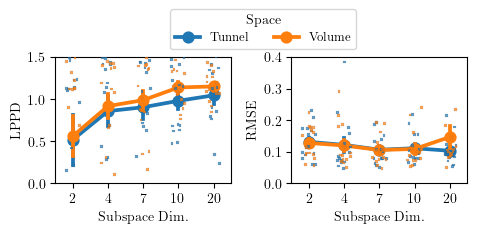

In [25]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu') & (
    df_best_t['Depth'] == 3) & (df_best_t['UniformSSampling'] == True)]
fig, ax = plt.subplots(1,2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.pointplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue='Space', ax=ax[0], errorbar='se', legend=False)
sns.stripplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue='Space', ax=ax[0], marker='s', legend=False, s=2, linewidth=0.1, alpha=0.7, jitter=0.2)
ax[0].set_ylim(0., 1.5)
ax[0].set_ylabel('LPPD')
sns.pointplot(data=df_subset, y='rmse_test',
            x='SubspaceDim', hue='Space', errorbar='se', ax=ax[1])
sns.stripplot(data=df_subset, y='rmse_test', x='SubspaceDim', hue='Space',
              ax=ax[1], marker='s', legend=False, s=2, linewidth=0.1, alpha=0.7, jitter=0.2)
ax[1].set_ylim(0., .4)
ax[1].set_ylabel('RMSE')
plt.tight_layout()
# ax[1].legend(loc='upper center', title='Space', bbox_to_anchor=(-.2, 1.45), ncols=2)
ax[0].set_xlabel('Subspace Dim.')
ax[1].set_xlabel('Subspace Dim.')
handlers, labels = ax[1].get_legend_handles_labels()
labels = ["Tunnel" if l == 'lambda' else 'Volume' for l in labels]
ax[1].get_legend().remove()
fig.legend(handlers, labels, loc='upper center', title='Space', bbox_to_anchor=(.55, 1.17), ncol=2)

# fig.savefig('figures/reg_best_t_lppd_test.pdf', bbox_inches='tight')

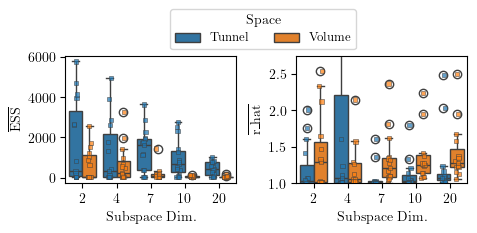

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.boxplot(data=df_subset, y='ess_mean', x='SubspaceDim', hue_order=hue_order,
            hue='Space', ax=ax[0], legend=False)
sns.stripplot(data=df_subset, y='ess_mean', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[0], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)
# ax[0].set_ylim(0., 4000)
ax[0].set_ylabel(r'$\overline{\textrm{ESS}}$')
sns.boxplot(data=df_subset, y='r_hat_mean',
            x='SubspaceDim', hue_order=hue_order, hue='Space', ax=ax[1])
sns.stripplot(data=df_subset, y='r_hat_mean', x='SubspaceDim', hue_order=hue_order, hue='Space',
              ax=ax[1], marker='s', legend=False, s=3, linewidth=0.5, alpha=0.7, dodge=True)

ax[1].set_ylim(1., 2.75)
ax[1].set_ylabel(r'$\overline{\textrm{r\_hat}}$')

ax[0].set_xlabel('Subspace Dim.')
ax[1].set_xlabel('Subspace Dim.')
handlers, labels = ax[1].get_legend_handles_labels()
labels = ["Tunnel" if l == 'lambda' else 'Volume' for l in labels]
ax[1].get_legend().remove()
fig.legend(handlers, labels, loc='upper center',
           title='Space', bbox_to_anchor=(.55, 1.17), ncol=2)

plt.tight_layout()
fig.savefig('figures/reg_best_t_sampling_metric_clean.pdf', bbox_inches='tight')

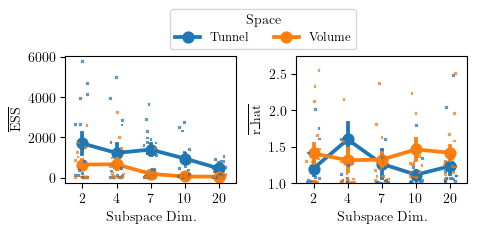

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t

sns.pointplot(data=df_subset, y='ess_mean', x='SubspaceDim',
              hue='Space', ax=ax[0], errorbar='se', legend=False)
sns.stripplot(data=df_subset, y='ess_mean', x='SubspaceDim', hue='Space',
              ax=ax[0], marker='s', legend=False, s=2, linewidth=0.1, alpha=0.7, jitter=0.2)
ax[0].set_ylabel(r'$\overline{\textrm{ESS}}$')
# ax[0].set_ylim(0., 4000)

sns.pointplot(data=df_subset, y='r_hat_mean', x='SubspaceDim',
              hue='Space', ax=ax[1], errorbar='se')
sns.stripplot(data=df_subset, y='r_hat_mean', x='SubspaceDim', hue='Space',
              ax=ax[1], marker='s', s=2, linewidth=0.1, alpha=0.7, jitter=0.2, legend=False)
ax[1].set_ylim(1., 2.75)
ax[1].set_ylabel(r'$\overline{\textrm{r\_hat}}$')

ax[0].set_xlabel('Subspace Dim.')
ax[1].set_xlabel('Subspace Dim.')
handlers, labels = ax[1].get_legend_handles_labels()
labels = ["Tunnel" if l == 'lambda' else 'Volume' for l in labels]
ax[1].get_legend().remove()
fig.legend(handlers, labels, loc='upper center',
           title='Space', bbox_to_anchor=(.55, 1.17), ncol=2)

plt.tight_layout()
# fig.savefig('figures/reg_best_t_sampling_metric.pdf', bbox_inches='tight')

### compare space and temperature vs subspace dimension

In [ ]:
api = wandb.Api()
results = []
# for s_id in ['vl6382k1', 'x26ip745', 'd8bi25u9']:
for s_id in ['66n5ud3d',]:
    t_bar = tqdm(api.sweep(f"ddold/subspace_sampling_compare/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config']['prior_scale'],
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       Depth=run.config['curve_params']['model_kwargs']['depth'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                       elpd_loo=run.summary.get('elpd_loo', -np.inf),
                       lppd_test=run.summary.get('elpd_test', np.nan),
                       rmse_test=run.summary.get('rmse_test', np.nan),
                       lppd_valid=run.summary.get('elpd_valid', np.nan),
                       rmse_valid=run.summary.get('rmse_valid', np.nan),
                       p_loo=run.summary.get('p_loo', np.inf),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}; state: {run.state}")
df = pd.DataFrame(results)
df

Sweep id: 66n5ud3d:   1%|          | 21/3405 [00:00<00:19, 169.94it/s, rose-sweep-3366]    

Encoundert problem with run restful-sweep-3405; state: running
Encoundert problem with run woven-sweep-3404; state: crashed
Encoundert problem with run celestial-sweep-3403; state: running


Sweep id: 66n5ud3d:   2%|▏         | 79/3405 [00:00<00:25, 130.22it/s, efficient-sweep-3326]

Encoundert problem with run lively-sweep-3341; state: crashed


Sweep id: 66n5ud3d:   9%|▉         | 321/3405 [00:01<00:13, 237.10it/s, jolly-sweep-3065]        

Encoundert problem with run devoted-sweep-3104; state: crashed


Sweep id: 66n5ud3d:  11%|█         | 371/3405 [00:01<00:13, 220.32it/s, flowing-sweep-3016]  

Encoundert problem with run ethereal-sweep-3062; state: crashed
Encoundert problem with run iconic-sweep-3027; state: crashed
Encoundert problem with run lively-sweep-3021; state: crashed


Sweep id: 66n5ud3d:  13%|█▎        | 431/3405 [00:02<00:13, 221.50it/s, dark-sweep-2966]     

Encoundert problem with run devout-sweep-3010; state: crashed
Encoundert problem with run flowing-sweep-3009; state: crashed
Encoundert problem with run autumn-sweep-3008; state: crashed
Encoundert problem with run lyric-sweep-3007; state: crashed
Encoundert problem with run swept-sweep-3006; state: crashed
Encoundert problem with run stoic-sweep-3005; state: crashed
Encoundert problem with run clear-sweep-3004; state: crashed
Encoundert problem with run fragrant-sweep-3003; state: crashed
Encoundert problem with run cerulean-sweep-3002; state: crashed
Encoundert problem with run fresh-sweep-3001; state: crashed


Sweep id: 66n5ud3d: 100%|██████████| 3405/3405 [00:17<00:00, 194.02it/s, serene-sweep-1]          


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,Depth,SubspaceDim,...,rmse_test,lppd_valid,rmse_valid,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,c82pm25x,nuts,lambda,0.5,0.1,25,2.154,elu,5,40,...,0.078473,1.556565,0.050298,9.782489,4551.760401,1.02,1.00375,720,3666.375,212.342606
1,v1gcb32h,nuts,lambda,0.5,0.1,25,1.000,elu,5,40,...,0.079504,1.579638,0.049787,5.56143,5293.887840,1.15,1.06650,43,530.725,219.358612
2,68k9bxeq,nuts,varphi,1.0,-1.0,-1,1000.000,elu,3,40,...,8.046881,-3.979361,2.627761,inf,21.688112,1.01,1.00125,1999,3911.025,110.504204
3,rukb9ak4,nuts,varphi,1.0,-1.0,-1,464.159,elu,3,40,...,3.793443,-3.167729,0.972339,inf,35.060887,1.07,1.01925,87,1855.025,144.677811
4,6licvg5q,nuts,varphi,1.0,-1.0,-1,215.443,elu,3,40,...,59.101196,-1.857102,0.432922,inf,35.861249,1.77,1.12475,15,169.625,144.244812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,jxyjfewm,nuts,lambda,0.5,0.1,25,21.544,relu,3,2,...,0.087100,1.196570,0.042637,33.207731,6.132575,1.00,1.00000,6147,6929.500,5.656600
3383,04pjepud,nuts,lambda,0.5,0.1,25,10.000,relu,3,2,...,0.098151,1.538519,0.044296,36.202427,10.182384,1.00,1.00000,2496,3142.500,7.644800
3384,kkxpy0gi,nuts,lambda,0.5,0.1,25,4.642,relu,3,2,...,0.070124,1.588738,0.046947,12.359263,12.436258,1.00,1.00000,860,1187.000,17.064800
3385,igypu2n8,nuts,lambda,0.5,0.1,25,2.154,relu,3,2,...,0.072121,1.612494,0.048039,6.394728,18.824338,1.03,1.02500,443,565.500,24.140800


In [ ]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,Depth,SubspaceDim,...,rmse_test,lppd_valid,rmse_valid,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward


In [ ]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
variable_idx = []
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        unique_ = df_clean[c].unique()
        print(c, unique_)
        if (len(unique_) > 1) and (c != 'Seed'):
            variable_idx.append(c)
print(f"\nExperiment differs in {variable_idx} configs")

Unique configuartions: 
Sampler ['nuts']
Space ['lambda' 'varphi']
PriorScale [0.5 1. ]
TubeScale [ 0.1 -1. ]
Epsilon [25 -1]
Temperature [   2.154    1.    1000.     464.159  215.443  100.      46.416   21.544
   10.       4.642]
Activation ['elu' 'relu']
Depth [ 5  3 10]
SubspaceDim [40 20 10  7  4  2]
Seed [10 14 13 12 11]
PriorCorrection ['only t']
SelectFromValidation [ True]

Experiment differs in ['Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'Activation', 'Depth', 'SubspaceDim'] configs


In [ ]:
variable_idx = np.setdiff1d(variable_idx, ['PriorScale', 'TubeScale', 'Epsilon'])
variable_idx

array(['Activation', 'Depth', 'Space', 'SubspaceDim', 'Temperature'],
      dtype='<U11')

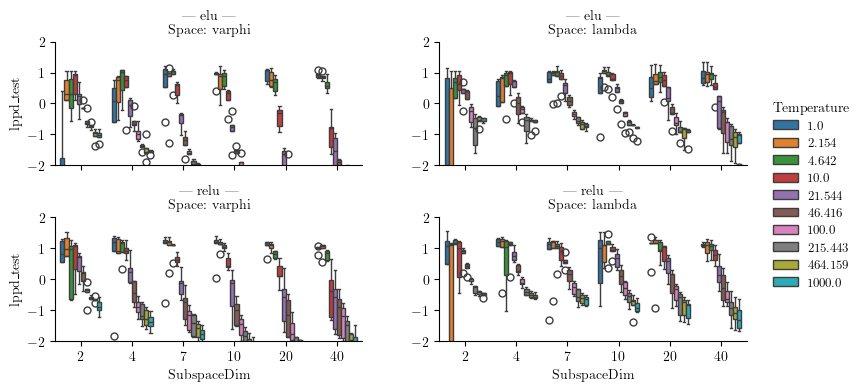

In [ ]:
df_subset = df_clean[df_clean['Depth'] == 3]
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=2, palette='tab10')
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
g.tight_layout()
# set ylim
for ax in g.axes.flatten():
    ax.set_ylim(-2, 2)

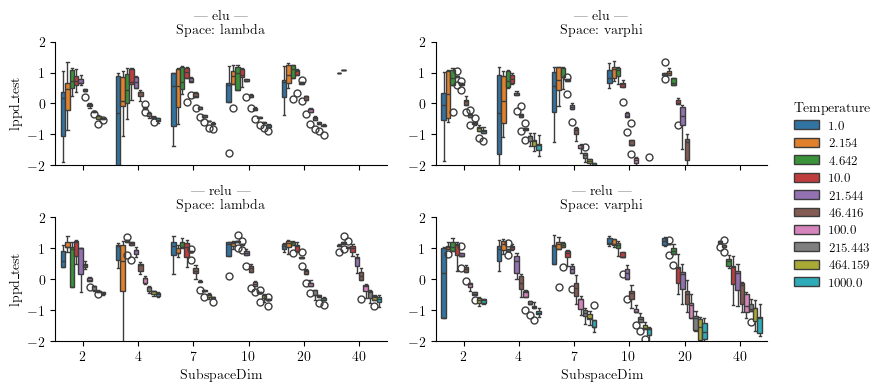

In [ ]:
df_subset = df_clean[df_clean['Depth'] == 5]
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=2, palette='tab10')
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
g.tight_layout()
# set ylim
for ax in g.axes.flatten():
    ax.set_ylim(-2, 2)

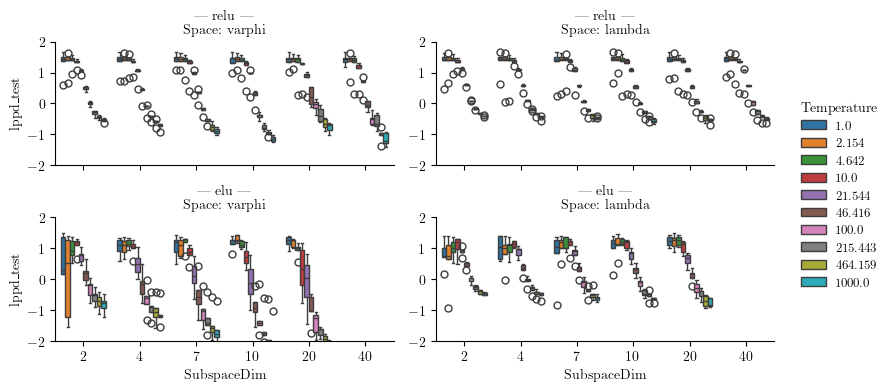

In [ ]:
df_subset = df_clean[df_clean['Depth'] == 10]
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Space', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=2, palette='tab10')
g.set_titles(row_template='--- {row_name}',
             col_template='\nSpace: {col_name}')
g.tight_layout()
# set ylim
for ax in g.axes.flatten():
    ax.set_ylim(-2, 2)

In [ ]:
idx_max_lppd_valid = df_clean.groupby(
    ['Depth', 'Activation', 'SubspaceDim', 'Space', 'Seed'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(['Depth', 'Activation','Space', 'SubspaceDim']).mean()

elpd_loo  lppd_test   rmse_test  \
Depth Activation Space  SubspaceDim                                      
3     elu        lambda 2            113.778536 -67.422179    6.611419   
                        4            110.863196 -59.228126    2.113559   
                        7            106.495725   0.719200    0.370918   
                        10           104.682949   0.504334    0.258723   
                        20           104.171194   0.751261    0.547830   
...                                         ...        ...         ...   
10    relu       varphi 4            109.496902   1.348719    0.057814   
                        7            104.390312   1.420971    0.096728   
                        10           102.286473   1.394037    1.722762   
                        20           100.592986   1.415214  329.044026   
                        40           105.287569   1.417830  571.804997   

                                     lppd_valid  rmse_valid      p_loo  \
Depth Activation Space  SubspaceDim                                      
3     elu        lambda 2              1.650746    0.046137   4.237074   
                        4              1.620788    0.048039   6.856058   
                        7              1.554747    0.050545   9.492405   
                        10             1.553319    0.050999  11.383987   
                        20             1.521578    0.052852  10.740108   
...                                         ...         ...        ...   
10    relu       varphi 4              1.600290    0.048965   2.531404   
                        7              1.539103    0.051660   4.522492   
                        10             1.511955    0.052616   6.803586   
                        20             1.494336    0.052489   6.400995   
                        40             1.513785    0.065924   4.095422   

                                         time_s  r_hat_max  r_hat_mean  \
Depth Activation Space  SubspaceDim                                      
3     elu        lambda 2              9.885474      1.010     1.00900   
                        4             20.738263      1.014     1.00950   
                        7             55.922493      1.102     1.05800   
                        10           153.503720      1.042     1.02100   
                        20           944.669591      1.142     1.05590   
...                                         ...        ...         ...   
10    relu       varphi 4             45.092586      1.110     1.06050   
                        7             56.018208      1.072     1.04800   
                        10            66.597898      2.336     1.93760   
                        20            58.357671      2.290     1.58090   
                        40            62.501545      3.034     2.12665   

                                     ess_min     ess_mean  num_forward  
Depth Activation Space  SubspaceDim                                     
3     elu        lambda 2             2415.2  3010.900000     8.017400  
                        4             1438.6  2451.000000    18.414881  
                        7              372.4  1405.114286    39.301801  
                        10             386.0  1377.600000    75.135384  
                        20             180.8  1255.190000   188.040749  
...                                      ...          ...          ...  
10    relu       varphi 4              246.6   436.400000    64.762122  
                        7              206.6   325.085714    97.481785  
                        10              16.6    29.000000   124.943624  
                        20              12.8    21.090000    83.545583  
                        40              11.6    14.990000    98.526244  

[69 rows x 12 columns]

(0.02, 0.07)

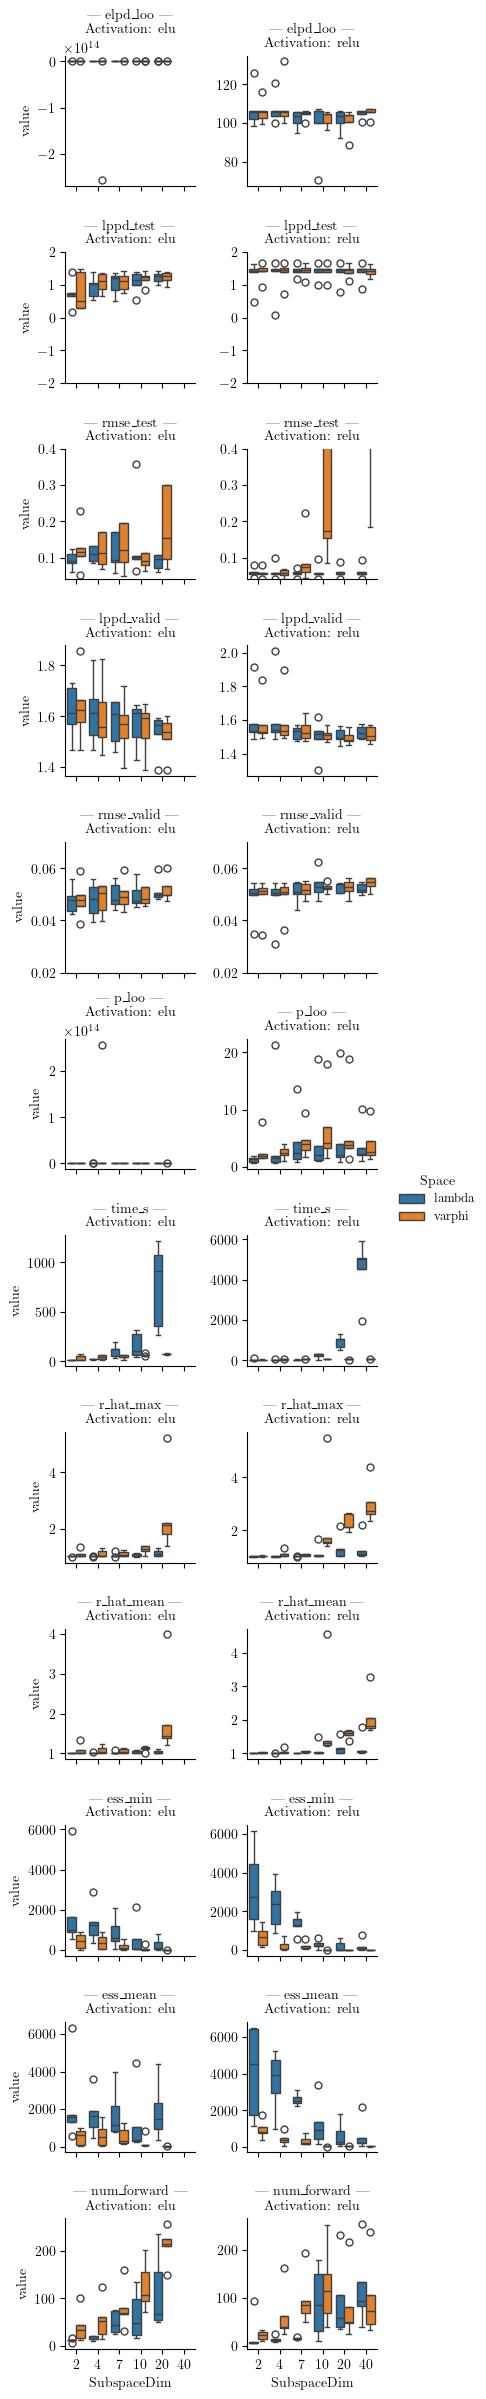

In [ ]:
df_subset = df_best_t[df_best_t['Depth'] == 10]
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)

g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
                col='Activation', row='metric', kind='box', hue='Space', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nActivation: {col_name}')
g.tight_layout()
g.axes[1, 0].set_ylim(-2, 2)
g.axes[1, 1].set_ylim(-2, 2)
g.axes[2, 0].set_ylim(0.04, 0.4)
g.axes[2, 1].set_ylim(0.04, 0.4)
g.axes[4, 0].set_ylim(0.02, 0.07)
g.axes[4, 1].set_ylim(0.02, 0.07)

In [ ]:
# elu net has more interesting data distribution

(0.0, 1.6213667511940002)

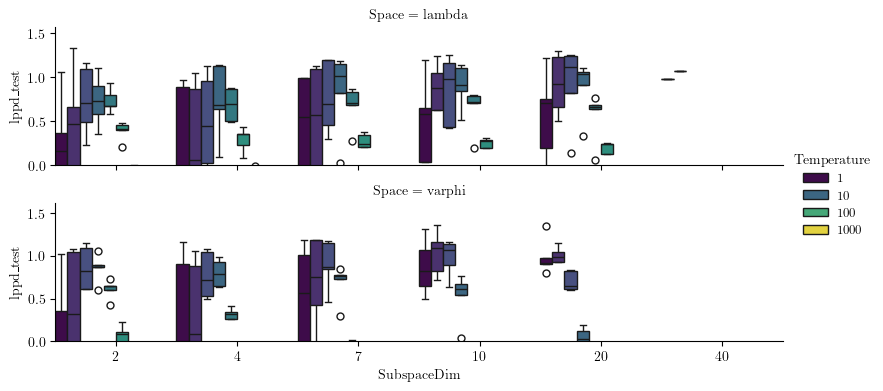

In [ ]:
from matplotlib import colors
df_subset = df_clean[(df_clean['Activation'] == 'elu')
                     & (df_clean['Depth'] == 5)]
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                row='Space', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))
g.axes[0, 0].set_ylim(0, )
g.axes[1, 0].set_ylim(0, )
# g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

(-1.0, 1.6213667511940002)

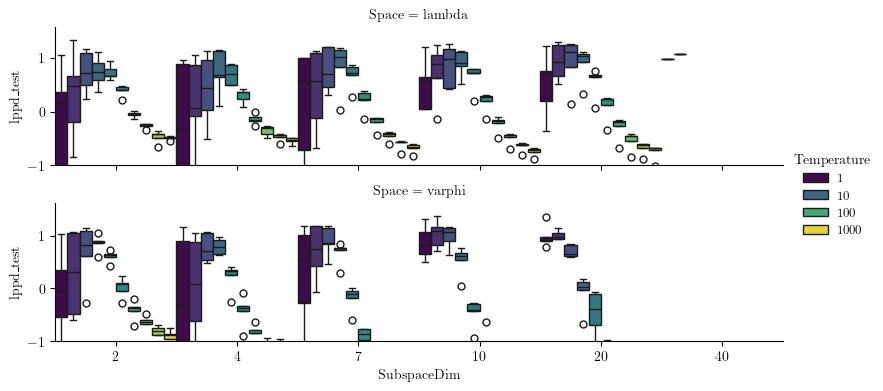

In [ ]:
from matplotlib import colors
df_subset = df_clean[(df_clean['Activation'] == 'elu') & (df_clean['Depth'] == 5)]
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                row='Space', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))
g.axes[0, 0].set_ylim(-1, )
g.axes[1, 0].set_ylim(-1, )
# g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

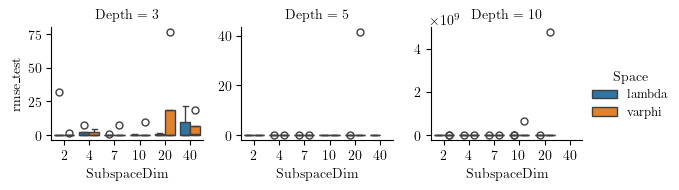

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu')]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Depth', kind='box', hue='Space', sharey=False, height=figsize[1])
# g.axes[1, 0].set_ylim(-2, 2)
# g.axes[1, 1].set_ylim(-2, 2)
# g.axes[0, 0].set_ylim(0.04, 0.4)
# g.axes[0, 1].set_ylim(0.04, 0.4)
# g.axes[0, 0].set_ylim(0.02, 0.07)
# g.axes[0, 1].set_ylim(0.02, 0.07)
g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

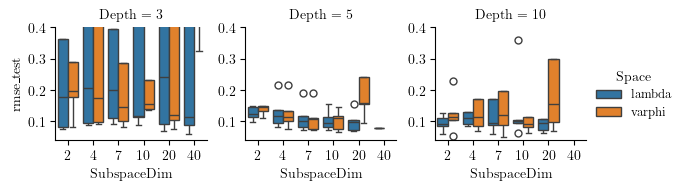

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu')]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Depth', kind='box', hue='Space', sharey=False, height=figsize[1])
# g.axes[1, 0].set_ylim(-2, 2)
# g.axes[1, 1].set_ylim(-2, 2)
g.axes[0, 0].set_ylim(0.04, 0.4)
g.axes[0, 1].set_ylim(0.04, 0.4)
g.axes[0, 2].set_ylim(0.04, 0.4)
# g.axes[0, 0].set_ylim(0.02, 0.07)
# g.axes[0, 1].set_ylim(0.02, 0.07)
g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

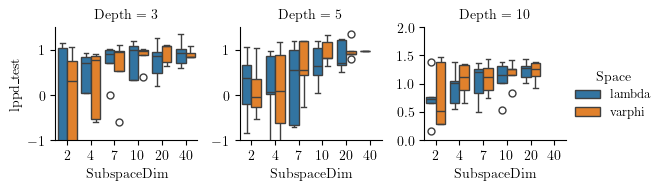

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu')]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Depth', kind='box', hue='Space', sharey=False, height=figsize[1])
g.axes[0, 0].set_ylim(-1., 1.5)
g.axes[0, 1].set_ylim(-1., 1.5)
g.axes[0, 2].set_ylim(0., 2.)
g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

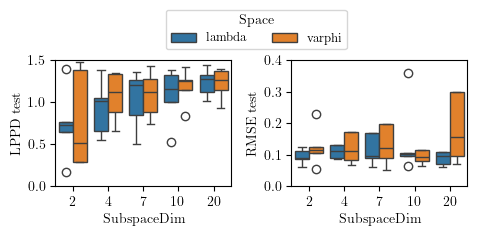

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu') & (df_best_t['Depth'] == 10)]
fig, ax = plt.subplots(1,2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.boxplot(data=df_subset, y='lppd_test', x='SubspaceDim', hue='Space', ax=ax[0], legend=False)
ax[0].set_ylim(0., 1.5)
ax[0].set_ylabel('LPPD test')
sns.boxplot(data=df_subset, y='rmse_test',
            x='SubspaceDim', hue='Space', ax=ax[1])
ax[1].set_ylim(0., .4)
ax[1].set_ylabel('RMSE test')
plt.tight_layout()
ax[1].legend(loc='upper center', title='Space', bbox_to_anchor=(-.2, 1.45), ncols=2)
fig.savefig('figures/reg_best_t_lppd_test.pdf', bbox_inches='tight')
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

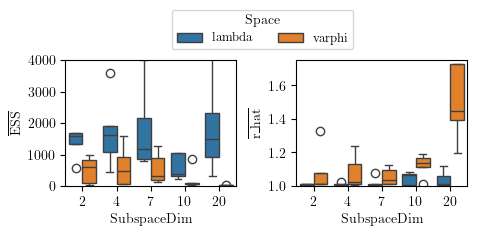

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu')
                      & (df_best_t['Depth'] == 10)]
fig, ax = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
# df_subset = df_best_t
sns.boxplot(data=df_subset, y='ess_mean', x='SubspaceDim',
            hue='Space', ax=ax[0], legend=False)
ax[0].set_ylim(0., 4000)
ax[0].set_ylabel(r'$\overline{\textrm{ESS}}$')
sns.boxplot(data=df_subset, y='r_hat_mean',
            x='SubspaceDim', hue='Space', ax=ax[1])
ax[1].set_ylim(1., 1.75)
ax[1].set_ylabel(r'$\overline{\textrm{r\_hat}}$')
plt.tight_layout()
ax[1].legend(loc='upper center', title='Space',
             bbox_to_anchor=(-.2, 1.45), ncols=2)
fig.savefig('figures/reg_best_t_sampling_metric.pdf', bbox_inches='tight')

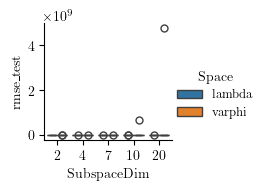

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu') & (df_best_t['Depth'] == 10)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim', hue='Space', kind='box', sharey=False, height=figsize[1])

(0.0, 2.0)

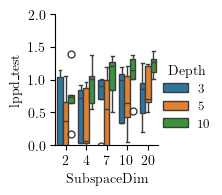

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu') & (df_best_t['Space'] == 'lambda')]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                kind='box', hue='Depth', sharey=False, height=figsize[1], palette='tab10')
g.axes[0,0].set_ylim(0, 2)

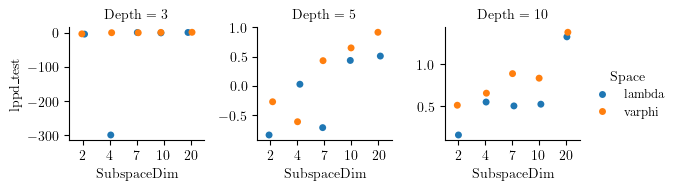

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu') & (df_best_t['Seed'] == 11)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                kind='strip',col="Depth", hue='Space', sharey=False, height=figsize[1], palette='tab10')
# g.axes[0, 0].set_ylim(0, 2)

In [ ]:
df_best_t.set_index(idx_ids).groupby(
    ['Depth', 'Activation', 'SubspaceDim', 'Seed']).describe()

lppd_test                          \
                                      count        mean         std   
Depth Activation SubspaceDim Seed                                     
3     elu        2           10         2.0    0.953575    0.285211   
                             11         2.0   -4.244890    0.523505   
                             12         2.0 -164.896490  233.643325   
                             13         2.0   -3.174310    1.983711   
                             14         2.0    1.045103    0.016844   
...                                     ...         ...         ...   
10    relu       20          10         2.0    1.451201    0.001577   
                             11         2.0    0.953106    0.240130   
                             12         2.0    1.490490    0.011643   
                             13         2.0    1.656359    0.001611   
                             14         2.0    1.380588    0.024414   

                                                                       \
                                          min         25%         50%   
Depth Activation SubspaceDim Seed                                       
3     elu        2           10      0.751900    0.852738    0.953575   
                             11     -4.615064   -4.429977   -4.244890   
                             12   -330.107269 -247.501880 -164.896490   
                             13     -4.577005   -3.875657   -3.174310   
                             14      1.033192    1.039148    1.045103   
...                                       ...         ...         ...   
10    relu       20          10      1.450086    1.450644    1.451201   
                             11      0.783309    0.868207    0.953106   
                             12      1.482257    1.486373    1.490490   
                             13      1.655221    1.655790    1.656359   
                             14      1.363325    1.371956    1.380588   

                                                       rmse_test              \
                                         75%       max     count        mean   
Depth Activation SubspaceDim Seed                                              
3     elu        2           10     1.054412  1.155250       2.0    0.962936   
                             11    -4.059804 -3.874717       2.0    0.176577   
                             12   -82.291100  0.314289       2.0   16.325164   
                             13    -2.472962 -1.771614       2.0    0.278415   
                             14     1.051059  1.057014       2.0    0.081363   
...                                      ...       ...       ...         ...   
10    relu       20          10     1.451759  1.452316       2.0  686.609463   
                             11     1.038005  1.122903       2.0    3.770814   
                             12     1.494606  1.498722       2.0   82.509356   
                             13     1.656929  1.657498       2.0   26.415960   
                             14     1.389220  1.397851       2.0   23.454427   

                                   ...   ess_mean          num_forward  \
                                   ...        75%      max       count   
Depth Activation SubspaceDim Seed  ...                                   
3     elu        2           10    ...  1850.6250  1910.00         2.0   
                             11    ...  4253.7500  4799.50         2.0   
                             12    ...  5442.2500  6685.50         2.0   
                             13    ...  1954.2500  2146.50         2.0   
                             14    ...   871.8750  1068.50         2.0   
...                                ...        ...      ...         ...   
10    relu       20          10    ...   637.0125   843.50         2.0   
                             11    ...    18.1250    18.50         2.0   
                             12    ...  1335.1875  1774.10         2.0   
       

In [ ]:
idx_lambda_vs_phi = df_best_t.groupby(['Depth', 'Activation', 'Seed', 'SubspaceDim'])['lppd_test'].idxmax()
df_lambda_vs_phi = df_best_t.loc[idx_lambda_vs_phi]
outperform = df_lambda_vs_phi['Space'].value_counts()
print(f"Varphi wins: {outperform['varphi']}, Lambda wins: {outperform['lambda']} in lppd_test comparison") 

Varphi wins: 84, Lambda wins: 67 in lppd_test measure


In [ ]:
idx_lambda_vs_phi = df_best_t.groupby(
    ['Depth', 'Activation', 'Seed', 'SubspaceDim'])['rmse_test'].idxmin()
df_lambda_vs_phi = df_best_t.loc[idx_lambda_vs_phi]
outperform = df_lambda_vs_phi['Space'].value_counts()
print(
    f"Varphi wins: {outperform['varphi']}, Lambda wins: {outperform['lambda']} in rmse comparison")

Varphi wins: 59, Lambda wins: 92 in rmse measure


In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'elu') & (df_best_t['Depth'] == 3)]

idx_lambda_vs_phi = df_subset.groupby(
    ['Depth', 'Activation', 'Seed', 'SubspaceDim'])['lppd_test'].idxmax()
df_lambda_vs_phi = df_subset.loc[idx_lambda_vs_phi]
outperform = df_lambda_vs_phi['Space'].value_counts()
print(
    f"Varphi wins: {outperform['varphi']}, Lambda wins: {outperform['lambda']} in lppd_test comparison")

idx_lambda_vs_phi = df_subset.groupby(
    ['Depth', 'Activation', 'Seed', 'SubspaceDim'])['rmse_test'].idxmin()
df_lambda_vs_phi = df_subset.loc[idx_lambda_vs_phi]
outperform = df_lambda_vs_phi['Space'].value_counts()
print(
    f"Varphi wins: {outperform['varphi']}, Lambda wins: {outperform['lambda']} in rmse comparison")

Varphi wins: 14, Lambda wins: 11 in lppd_test comparison
Varphi wins: 13, Lambda wins: 12 in rmse comparison


In [ ]:
df_subset = df_best_t[df_best_t['Activation'] == 'relu']
df_subset.set_index(idx_ids).groupby(
    ['Space', 'Depth', 'SubspaceDim'])[['lppd_test', 'rmse_test']].agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(3).astype(
        str) + " ± " + x['rmse_test_std'].round(3).astype(str),
    lppd_test=lambda x: x['lppd_test_mean'].round(3).astype(
        str) + " ± " + x['lppd_test_std'].round(3).astype(str)
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])

rmse_test       lppd_test
Space  Depth SubspaceDim                                   
lambda 3     2                0.163 ± 0.133  -1.348 ± 3.442
             4                0.175 ± 0.144   0.491 ± 0.965
             7                0.086 ± 0.028   0.987 ± 0.475
             10               0.098 ± 0.048   0.815 ± 0.678
             20               0.104 ± 0.064    0.787 ± 0.96
       5     2                0.171 ± 0.091    0.411 ± 0.63
             4                0.104 ± 0.067    0.89 ± 0.375
             7                0.087 ± 0.028    0.91 ± 0.441
             10               0.119 ± 0.088   1.046 ± 0.185
             20               0.087 ± 0.022   1.079 ± 0.145
       10    2                0.059 ± 0.013   1.284 ± 0.466
             4                0.062 ± 0.022   1.219 ± 0.642
             7                0.057 ± 0.011   1.427 ± 0.179
             10                0.061 ± 0.02   1.406 ± 0.255
             20                0.06 ± 0.017   1.357 ± 0.335
varphi 3     2                0.112 ± 0.072  -1.045 ± 4.645
             4                0.118 ± 0.064   0.537 ± 1.346
             7                0.084 ± 0.025   0.849 ± 0.914
             10               0.096 ± 0.048   1.009 ± 0.552
             20               3.735 ± 7.463    1.13 ± 0.082
             40                 0.225 ± nan     1.026 ± nan
       5     2                0.176 ± 0.151  -0.422 ± 1.776
             4                0.126 ± 0.065   0.819 ± 0.309
             7                0.105 ± 0.064   0.914 ± 0.417
             10               0.072 ± 0.015   1.202 ± 0.112
             20               0.435 ± 0.496   1.231 ± 0.116
       10    2                0.058 ± 0.014   1.387 ± 0.268
             4                0.058 ± 0.011    1.349 ± 0.36
             7                0.097 ± 0.072    1.421 ± 0.21
             10               1.723 ± 2.852   1.394 ± 0.244
             20           329.044 ± 586.617   1.415 ± 0.195

In [ ]:
df_subset.set_index(idx_ids).groupby(
    ['Space', 'Depth', 'SubspaceDim']).describe()

lppd_test                                          \
                             count      mean       std       min       25%   
Space  Depth SubspaceDim                                                     
lambda 3     2                 5.0 -1.347758  3.442441 -5.315670 -4.914986   
             4                 5.0  0.491473  0.964775 -1.042456  0.128800   
             7                 5.0  0.987157  0.474844  0.162254  1.025132   
             10                5.0  0.815028  0.677861 -0.124236  0.377393   
             20                5.0  0.787198  0.959687 -0.922471  1.157078   
       5     2                 5.0  0.410665  0.630384 -0.258886 -0.241938   
             4                 5.0  0.890476  0.375447  0.370963  0.618235   
             7                 5.0  0.909921  0.441199  0.165083  0.858688   
             10                5.0  1.045533  0.185401  0.758937  0.962029   
             20                5.0  1.078751  0.144564  0.889959  0.969169   
       10    2                 5.0  1.283778  0.466007  0.465805  1.406471   
             4                 5.0  1.218837  0.641617  0.083102  1.409016   
             7                 5.0  1.427080  0.178513  1.171074  1.390212   
             10                5.0  1.405822  0.255274  0.982563  1.402144   
             20                5.0  1.357484  0.334998  0.783309  1.397851   
varphi 3     2                 5.0 -1.045031  4.645245 -9.342437  0.738711   
             4                 5.0  0.537274  1.346473 -1.824619  0.841410   
             7                 5.0  0.849215  0.914493 -0.782525  1.178446   
             10                5.0  1.009380  0.552072  0.032602  1.161703   
             20                5.0  1.129571  0.081867  1.006122  1.105627   
             40                1.0  1.026307       NaN  1.026307  1.026307   
       5     2                 5.0 -0.421667  1.776335 -3.120560 -1.265225   
             4                 5.0  0.818569  0.309026  0.268273  0.912355   
             7                 5.0  0.914179  0.416647  0.481216  0.483627   
             10                5.0  1.202054  0.111793  1.066659  1.126810   
             20                5.0  1.231296  0.116346  1.090549  1.141976   
       10    2                 5.0  1.387313  0.268250  0.940266  1.413129   
             4                 5.0  1.348719  0.360196  0.728170  1.406468   
             7                 5.0  1.420971  0.210191  1.092447  1.385185   
             10                5.0  1.394037  0.244118  0.995753  1.380112   
             20                5.0  1.415214  0.195289  1.122903  1.363325   

                                                       rmse_test              \
                               50%       75%       max     count        mean   
Space  Depth SubspaceDim                                                       
lambda 3     2            1.122583  1.143040  1.226244       5.0    0.162919   
             4            1.038238  1.046566  1.286216       5.0    0.174901   
             7            1.199319  1.204511  1.344570       5.0    0.086274   
             10           1.023966  1.260239  1.537779       5.0    0.098056   
             20           1.163007  1.173396  1.364982       5.0    0.104351   
       5     2            0.584999  0.870091  1.099057       5.0    0.170766   
             4            1.071595  1.178627  1.212960       5.0    0.104364   
             7            1.093814  1.212869  1.219151       5.0    0.087092   
             10           1.126303  1.188765  1.191633       5.0    0.119380   
             20           1.136067  1.156822  1.241736       5.0    0.086998   
       10    2            1.416705  1.498903  1.631007       5.0    0.058967   
             4            1.450178  1.498299  1.653589       5.0    0.062381   
             7            1.413283  1.498701  1.662132       5.0    0.057294   
             10           1.481330  1.497736  1.665335       5.0    0.060950   
            

### Load sampler compare

In [9]:
api = wandb.Api()
results = []
for s_id in ['vl6382k1', 'x26ip745', 'd8bi25u9']:
    # for s_id in ['o9oa1zu7',]:
    t_bar = tqdm(api.sweep(f"ddold/subspace_sampling_compare/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config']['prior_scale'],
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       Fast=run.config['sampling']['space_config'].get(
                           'prior_correct', False),
                       elpd_loo=run.summary.get('elpd_loo', np.nan),
                       p_loo=run.summary.get('p_loo', np.nan),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}")

df = pd.DataFrame(results)
df

Sweep id: d8bi25u9:  17%|█▋        | 41/245 [00:00<00:00, 405.54it/s, usual-sweep-165]      

Encoundert problem with run classic-sweep-245


Sweep id: d8bi25u9: 100%|██████████| 245/245 [00:00<00:00, 381.00it/s, fresh-sweep-1]       


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,Fast,elpd_loo,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,7m4azyz8,mclmc,lambda,0.5,0.1,25,3,tanh,30,4,False,90.200641,20.598363,1974.213538,1.07,1.029333,111.0,1251.133333,226.000000
1,z41wx1kk,mclmc,lambda,0.5,0.1,25,1,tanh,30,4,False,106.003532,5.878042,1759.916011,1.09,1.029000,71.0,717.033333,202.000000
2,4ypi9xpu,mclmc,lambda,0.5,1.0,25,3,tanh,30,4,False,70.117676,39.611105,2222.920065,1.18,1.036667,42.0,404.066667,249.000000
3,tlxcac4l,mclmc,lambda,0.5,1.0,25,1,tanh,30,4,False,102.734599,10.190581,2258.274213,1.49,1.072000,19.0,217.666667,252.000000
4,t1lkest3,mclmc,varphi,1.0,-1.0,-1,3,tanh,30,4,False,66.889767,41.800292,13.772128,1.85,1.275000,15.0,37.733333,125.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,clv7i0uy,nuts,lambda,0.5,0.1,25,1,relu,5,2,False,115.298931,3.216926,7.041922,1.03,1.022000,411.0,501.600000,23.691200
888,1mgair7i,nuts,lambda,0.5,1.0,25,3,relu,5,2,False,99.199968,14.981467,7.090683,1.05,1.040000,130.0,278.400000,22.281500
889,glxxu389,nuts,lambda,0.5,1.0,25,1,relu,5,2,False,114.995273,3.431257,7.145279,1.02,1.012000,553.0,688.200000,24.202400
890,d52wzgd9,nuts,varphi,1.0,-1.0,-1,3,relu,5,2,False,99.191238,14.896323,2.627225,1.06,1.036000,117.0,338.000000,22.540701


In [10]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,Fast,elpd_loo,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
22,2xe93ru0,mclmc,varphi,1.0,-1.0,-1,3,elu,30,4,False,NaN,NaN,13.054062,NaN,NaN,NaN,NaN,122.0
23,6d5ad45y,mclmc,varphi,1.0,-1.0,-1,1,elu,30,4,False,NaN,NaN,12.777790,NaN,NaN,NaN,NaN,124.5
29,cup0boxy,random_walk,varphi,1.0,-1.0,-1,1,elu,30,4,False,112.462736,0.572789,7.716134,NaN,NaN,10.0,10.0,249.0
39,fs9jltq4,mclmc,lambda,0.5,1.0,25,1,relu,30,4,False,NaN,NaN,1673.431926,NaN,NaN,NaN,NaN,237.0
40,uj57juva,mclmc,varphi,1.0,-1.0,-1,3,relu,30,4,False,NaN,NaN,10.138183,2.18,1.597333,13.0,18.7,125.5
46,j9l0h28e,random_walk,varphi,1.0,-1.0,-1,3,relu,30,4,False,110.243838,5.548747,3.593463,NaN,NaN,10.0,10.0,251.0
65,eafn9xaf,random_walk,varphi,1.0,-1.0,-1,1,tanh,20,4,False,112.470778,0.245969,8.111510,NaN,NaN,10.0,10.0,247.0
281,4kimrr5h,random_walk,varphi,1.0,-1.0,-1,1,elu,30,0,False,112.878654,0.464156,6.834548,NaN,NaN,10.0,10.0,251.0
291,0k6vnfj1,mclmc,lambda,0.5,1.0,25,1,relu,30,1,False,NaN,NaN,1342.099524,NaN,NaN,NaN,NaN,252.0
293,mk4k3dw1,mclmc,varphi,1.0,-1.0,-1,1,relu,30,1,False,NaN,NaN,7.670878,NaN,NaN,NaN,NaN,126.5


In [11]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
# idx_ids = ['id', 'Sampler', 'Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'Activation', 'SubspaceDim', 'Seed', 'Fast']
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        print(c, df_clean[c].unique())

Unique configuartions: 
Sampler ['mclmc' 'random_walk' 'nuts']
Space ['lambda' 'varphi']
PriorScale [0.5 1. ]
TubeScale [ 0.1  1.  -1. ]
Epsilon [25 -1]
Temperature [3 1]
Activation ['tanh' 'elu' 'relu']
SubspaceDim [30 20 10  5]
Seed [4 1 0 3 2]
Fast [False]


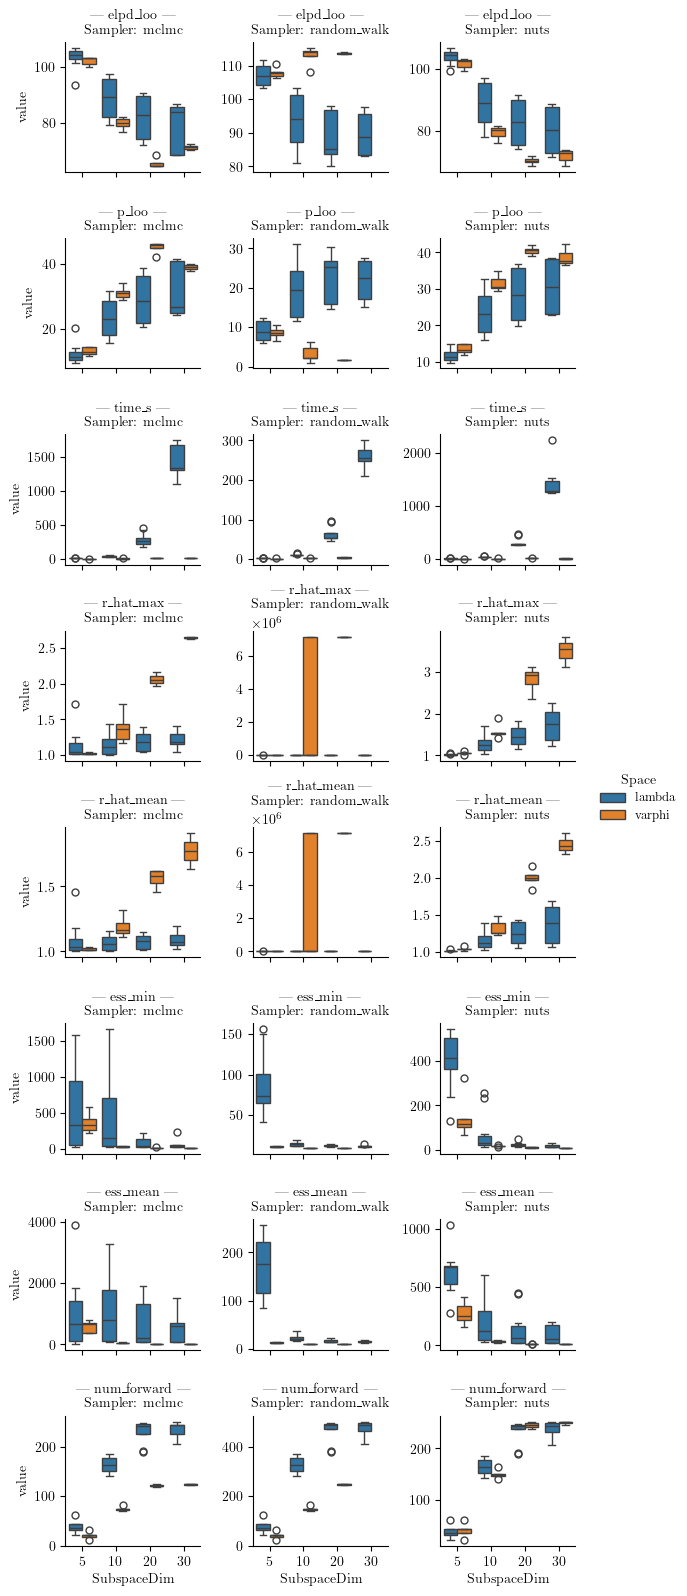

In [21]:
# check Tube scale
df_subset = df_clean[(df_clean['Temperature'] == 3.)
                     & (df_clean['Activation'] == 'relu')]
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)

g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
                col='Sampler', row='metric', kind='box', hue='Space', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nSampler: {col_name}')
g.tight_layout()

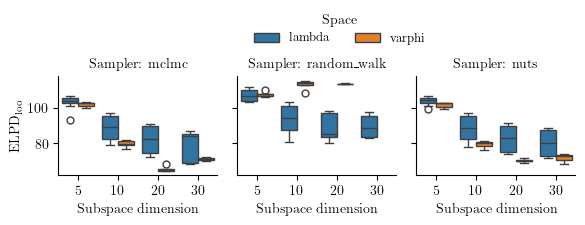

In [72]:
df_subset = df_clean[(df_clean['Temperature'] == 3.)
                     & (df_clean['Activation'] == 'relu')]

g = sns.catplot(data=df_subset, y='elpd_loo', x='SubspaceDim',
                col='Sampler', kind='box', hue='Space', sharey=True, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nSampler: {col_name}')
sns.move_legend(g, "center", bbox_to_anchor=(0.5, 1),
                ncol=2, title='Space', frameon=False)
g.tight_layout()
g.set_ylabels(r'$\mathrm{ELPD}_{\mathrm{loo}}$')
g.set_xlabels('Subspace dimension')
plt.savefig('figures/subspace_sampling_compare_elpd_loo.pdf', bbox_inches='tight')

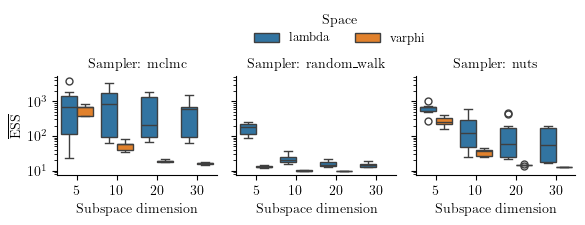

In [73]:
df_subset = df_clean[(df_clean['Temperature'] == 3.)
                     & (df_clean['Activation'] == 'relu')]

g = sns.catplot(data=df_subset, y='ess_mean', x='SubspaceDim',
                col='Sampler', kind='box', hue='Space', sharey=True, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nSampler: {col_name}')

sns.move_legend(g, "center", bbox_to_anchor=(0.5, 1),
                ncol=2, title='Space', frameon=False)
g.set(yscale='log')
g.tight_layout()
g.set_ylabels(r'$\overline{\mathrm{ESS}}$')
g.set_xlabels('Subspace dimension')
plt.savefig('figures/subspace_sampling_compare_ess.pdf', bbox_inches='tight')

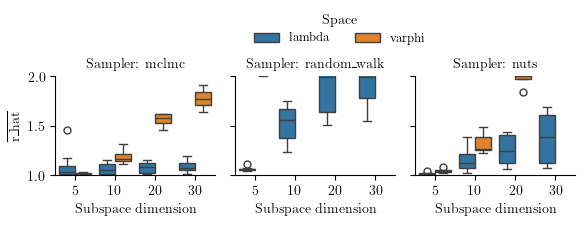

In [77]:
df_subset = df_clean[(df_clean['Temperature'] == 3.)
                     & (df_clean['Activation'] == 'relu')]

g = sns.catplot(data=df_subset, y='r_hat_mean', x='SubspaceDim',
                col='Sampler', kind='box', hue='Space', sharey=True, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nSampler: {col_name}')
# set only upper y lim
g.set(ylim=(1., 2.))
sns.move_legend(g, "center", bbox_to_anchor=(0.5, 1),
                ncol=2, title='Space', frameon=False)
g.set_ylabels(r'$\overline{\mathrm{r\_hat}}$')
g.set_xlabels('Subspace dimension')
g.tight_layout()
plt.savefig('figures/subspace_sampling_compare_rhat.pdf', bbox_inches='tight')

### compare prior effect

In [5]:
api = wandb.Api()
results = []
# for s_id in ['vl6382k1', 'x26ip745', 'd8bi25u9']:
for s_id in ['o9oa1zu7',]:
    t_bar = tqdm(api.sweep(f"ddold/subspace_sampling_compare/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(id=run.id,
                    Sampler=run.config['sampling']['sampler'],
                    Space=run.config['sampling']['space_config']['space'],
                    PriorScale=run.config['sampling']['space_config']['prior_scale'],
                    TubeScale=run.config['sampling']['space_config'].get('tube_scale', -1),
                    Epsilon=run.config['sampling']['space_config'].get('epsilon', -1),
                    Temperature=run.config['sampling']['temperature'],
                    Activation=run.config['curve_params']['model_kwargs']['activation'],
                    SubspaceDim=run.config['curve_params']['k'],
                    Seed=run.config['rng_seed'],
                PriorAdjust="JacDet" if run.config['sampling']['space_config'].get('prior_correct', False) else "None",
                    elpd_loo=run.summary.get('elpd_loo', np.nan),
                elpd_test=run.summary.get('elpd_test', np.nan),
                    p_loo=run.summary.get('p_loo', np.nan),
                    time_s=run.summary.get('time_s', np.nan),
                    r_hat_max=run.summary.get('r_hat_max', np.nan),
                    r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                    ess_min=run.summary.get('ess_min', np.nan),
                    ess_mean=run.summary.get('ess_mean', np.nan),
                    num_forward=run.summary.get('num_forward', np.nan),
                    )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}")

for s_id in ['4p0vdql0',]:
    t_bar = tqdm(api.sweep(f"ddold/subspace_sampling_compare/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config']['prior_scale'],
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorAdjust="t_scale" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) == False else "JacDet",
                       elpd_loo=run.summary.get('elpd_loo', np.nan),
                    elpd_test=run.summary.get('elpd_test', np.nan),
                       p_loo=run.summary.get('p_loo', np.nan),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}")

df = pd.DataFrame(results)
df

Sweep id: o9oa1zu7:  30%|███       | 41/136 [00:00<00:00, 370.48it/s, dry-sweep-57]       

Encoundert problem with run zesty-sweep-136
Encoundert problem with run good-sweep-134
Encoundert problem with run soft-sweep-132
Encoundert problem with run rural-sweep-130
Encoundert problem with run eager-sweep-58


Sweep id: 4p0vdql0: 100%|██████████| 75/75 [00:00<00:00, 471.13it/s, hopeful-sweep-1]   


,id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,PriorAdjust,elpd_loo,elpd_test,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,4fag7zbh,nuts,lambda,0.5,0.1,25,3,elu,40,12,None,95.524843,39.253647,15.991234,151.584538,1.05,1.005,144,2488.850,252.422806
1,59ive9us,nuts,lambda,0.5,0.1,25,3,elu,40,11,None,94.920597,35.746246,16.343334,98.514792,1.10,1.015,81,1685.375,251.063797
2,9qeeghuf,nuts,lambda,0.5,0.1,25,3,elu,40,10,None,95.001600,37.024185,16.168553,106.992109,1.12,1.048,57,572.850,236.114502
3,oox18gh4,nuts,lambda,0.5,0.1,25,3,relu,40,14,None,86.025958,39.419571,24.471245,100.857859,1.28,1.041,26,737.600,252.834702
4,h02yvanb,nuts,lambda,0.5,0.1,25,3,relu,40,13,JacDet,86.157709,41.335411,24.262764,36429.049875,1.26,1.079,30,160.425,234.323898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,vluzdgc9,nuts,lambda,0.5,0.1,25,3,relu,2,14,t_scale,115.041963,48.035862,3.440666,4.428488,1.02,1.015,874,1053.500,18.662802
202,7cvvzjv8,nuts,lambda,0.5,0.1,25,3,relu,2,13,t_scale,112.427582,51.206654,3.448396,3.981164,1.01,1.005,1110,1647.500,16.167000
203,dce3uxfm,nuts,lambda,0.5,0.1,25,3,relu,2,12,t_scale,113.349109,51.561028,3.745231,4.164734,1.01,1.010,944,1547.500,20.991800
204,rc0xmo8y,nuts,lambda,0.5,0.1,25,3,relu,2,11,t_scale,112.927828,47.703125,3.905281,4.761088,1.02,1.015,409,600.000,18.778200


In [6]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,PriorAdjust,elpd_loo,elpd_test,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward


In [7]:
df_clean = df[~idx_config_with_nan]
idx_ids = ['id', 'Sampler', 'Space', 'PriorScale', 'TubeScale', 'Epsilon',
           'Temperature', 'Activation', 'SubspaceDim', 'Seed', 'PriorAdjust']
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
for c in df_clean.columns:
    if c not in [*value_ids, 'id']:
        print(c, df_clean[c].unique())

Unique configuartions: 
Sampler ['nuts']
Space ['lambda']
PriorScale [0.5]
TubeScale [0.1]
Epsilon [25]
Temperature [3]
Activation ['elu' 'relu' 'tanh']
SubspaceDim [40 20 10  7  2]
Seed [12 11 10 14 13]
PriorAdjust ['None' 'JacDet' 't_scale']


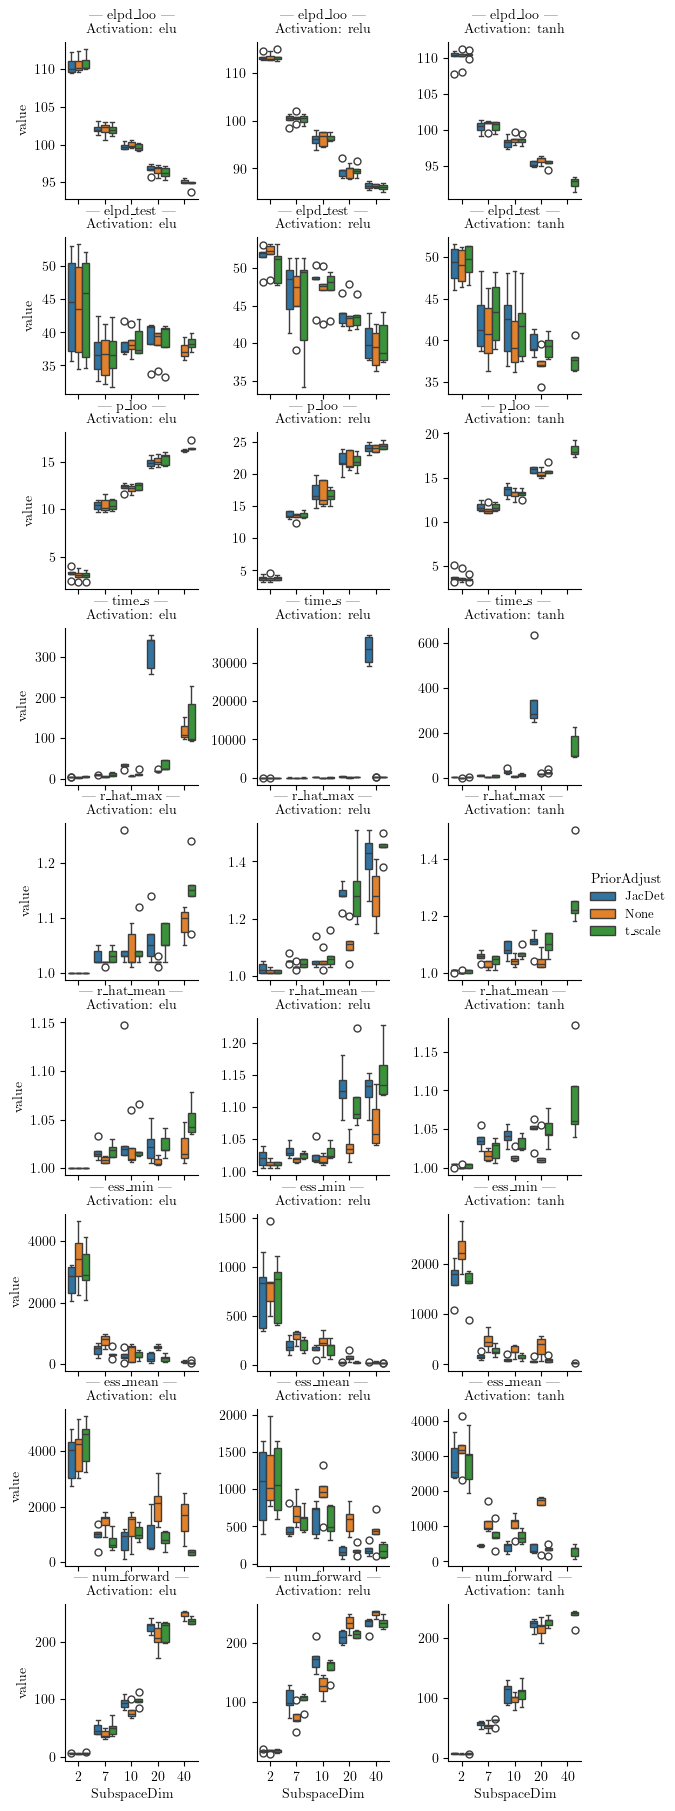

In [16]:
# check Tube scale
idx = (df_clean['Space'] == 'lambda') & (df_clean['PriorScale'] == .5) & (
    df_clean['Epsilon'] == 25) & (df_clean['Temperature'] == 3)
df_subset = df_clean.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)


g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
            col='Activation',row='metric', kind='box', hue='PriorAdjust', sharey=False, height=figsize[1])
# format title
g.set_titles(row_template='--- {row_name}', col_template='\nActivation: {col_name}')
g.tight_layout()

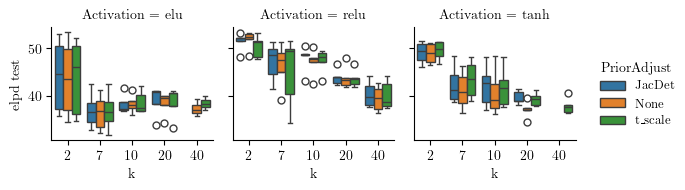

In [24]:
df_subset = df_clean.set_index(idx_ids)

g = sns.catplot(data=df_subset, y='elpd_test', x='SubspaceDim',
                col='Activation', kind='box', hue='PriorAdjust', palette='tab10', height=figsize[1])
# set y lim in facetgrid
# g.set(ylim=(-200, 50))

# Set titles with UseValid and Activation on two rows
# g.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
# for ax in g.axes.flat:
#     title = ax.get_title().split('|')
#     ax.set_title(f'{title[0]}\n{title[1]}', fontsize=12)
g.set_axis_labels('k', 'elpd test')
g.tight_layout()

### clean sample with nan in wandb 

In [ ]:
api = wandb.Api()
results = []
# # toy regression
for s_id in ['sohc5gqt', 'c3gv5slh']:
    t_bar = tqdm(api.sweep(f"ddold/subspace_toy_reg/{s_id}").runs)
# uci regression
# for s_id in ['xgfaa57w',]:
#     t_bar = tqdm(api.sweep(f"ddold/subspace_uc/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config']['prior_scale'],
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       Depth=run.config['curve_params']['model_kwargs']['depth'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                       UniformSSampling=run.config['curve_params']['uniform_t_optimize'],
                       elpd_loo=run.summary.get('elpd_loo', -np.inf),
                       lppd_test=run.summary.get('elpd_test', np.nan),
                       rmse_test=run.summary.get('rmse_test', np.nan),
                       lppd_valid=run.summary.get('elpd_valid', np.nan),
                       rmse_valid=run.summary.get('rmse_valid', np.nan),
                       p_loo=run.summary.get('p_loo', np.inf),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}; state: {run.state}")
df = pd.DataFrame(results)
df

Sweep id: sohc5gqt:   0%|          | 0/1200 [00:00<?, ?it/s, clear-sweep-1196]  

Sweep id: c3gv5slh: 100%|██████████| 2400/2400 [00:06<00:00, 365.30it/s, fallen-sweep-1]          


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,Depth,SubspaceDim,...,rmse_test,lppd_valid,rmse_valid,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,b9lxs97d,mclmc,varphi,1.0,-1.0,-1,316.227766,elu,3,20,...,3.496463,-3.703845,2.440396,inf,10.676659,1.00,1.0000,7158,7665.35,50
1,30706n6d,mclmc,varphi,1.0,-1.0,-1,100.000000,elu,3,20,...,1.546711,-3.278291,0.993652,inf,10.640293,1.00,1.0000,6037,6570.30,50
2,7cxvq5cb,mclmc,varphi,1.0,-1.0,-1,31.622777,elu,3,20,...,0.660945,-2.410574,0.344623,534.056110,13.997868,1.00,1.0000,3859,4691.95,50
3,aszert57,mclmc,varphi,1.0,-1.0,-1,10.000000,elu,3,20,...,0.345202,-0.252571,0.093333,94.903816,13.928669,1.03,1.0160,343,883.55,50
4,xqm5jdjb,mclmc,varphi,1.0,-1.0,-1,3.162278,elu,3,20,...,0.146382,1.259819,0.063232,31.215367,14.190657,1.14,1.0665,50,150.00,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,7lfej3uf,mclmc,lambda,0.5,0.1,25,100.000000,relu,3,2,...,0.091941,-0.029354,0.072979,166.813483,35.885978,1.00,1.0000,9829,9982.00,100
3596,fcfhu5ck,mclmc,lambda,0.5,0.1,25,31.622777,relu,3,2,...,0.058972,0.689234,0.065023,73.517562,35.949899,1.00,1.0000,9943,10008.00,100
3597,py2yrf24,mclmc,lambda,0.5,0.1,25,10.000000,relu,3,2,...,0.051644,1.249221,0.061321,26.518887,33.966570,1.00,1.0000,9520,9634.50,100
3598,2575qa7e,mclmc,lambda,0.5,0.1,25,3.162278,relu,3,2,...,0.057845,1.348282,0.062194,9.719659,33.472742,1.00,1.0000,1978,2646.50,100


In [ ]:

# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
rerun_ids = df[idx_config_with_nan]['Id'].values
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,Depth,SubspaceDim,...,rmse_test,lppd_valid,rmse_valid,p_loo,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
1207,4tkxsrs9,mclmc,lambda,0.5,0.1,25,316.227766,elu,3,20,...,NaN,NaN,NaN,inf,440.709479,NaN,NaN,NaN,NaN,100
1208,91q27p4v,mclmc,lambda,0.5,0.1,25,100.000000,elu,3,20,...,NaN,NaN,NaN,inf,406.082957,NaN,NaN,NaN,NaN,100
1209,r35utodf,mclmc,lambda,0.5,0.1,25,31.622777,elu,3,20,...,NaN,NaN,NaN,inf,396.538483,NaN,NaN,NaN,NaN,100
1218,eeglos10,mclmc,varphi,1.0,-1.0,-1,1.000000,elu,3,20,...,NaN,NaN,NaN,inf,11.688197,NaN,NaN,NaN,NaN,50
1219,azwvx340,mclmc,lambda,0.5,0.1,25,316.227766,elu,3,20,...,NaN,NaN,NaN,inf,634.801088,NaN,NaN,NaN,NaN,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,z3h7za53,mclmc,varphi,1.0,-1.0,-1,100.000000,relu,3,2,...,NaN,NaN,NaN,inf,11.390689,NaN,NaN,NaN,NaN,50
3509,z3ev6sdl,mclmc,varphi,1.0,-1.0,-1,1.000000,relu,3,2,...,NaN,NaN,NaN,inf,11.496472,NaN,NaN,NaN,NaN,50
3533,wygtn088,mclmc,varphi,1.0,-1.0,-1,1.000000,relu,3,2,...,NaN,NaN,NaN,inf,11.362059,NaN,NaN,NaN,NaN,50
3541,ua3o52f1,mclmc,varphi,1.0,-1.0,-1,100.000000,relu,3,2,...,NaN,NaN,NaN,inf,11.221314,NaN,NaN,NaN,NaN,50


In [ ]:
# clean_samples.posterior
def aZsamples_to_model_samples(az_samples):
    return {'scale': az_samples.posterior['scale'].values,
            't': az_samples.posterior['t'].values,
            'tube': az_samples.posterior['tube'].values, }

def aZsamples_to_model_samples_phi(az_samples):
    return {'scale': az_samples.posterior['scale'].values,
            'varphi': az_samples.posterior['varphi'].values}


def aZsamples_to_model_samples_line(az_samples):
    return {'scale': az_samples.posterior['scale'].values,
            't': az_samples.posterior['t'].values}


def compute_metrics(rng_key, x, y, sampling_model, num_chains, posterior):
    def log_like_fn(x, y):
        def single_log_like_fn(sample):
            with handlers.seed(rng_seed=0):
                cml = handlers.condition(sampling_model, data=sample)
                ex_trace = handlers.trace(cml).get_trace(
                    x, y, config['sampling']['temperature'])
                site = ex_trace['obs']
                log_like = site['fn'].log_prob(
                    site['value'])
                return log_like
        return jax.vmap(lambda sample: jax.lax.map(single_log_like_fn, sample))(posterior)

    def prediction(key, x):
        sample_keys = jax.random.split(key, num_chains)
        def single_prediction_fn(rng_key, sample):
            rng_key, sample_key = random.split(rng_key)
            with handlers.seed(rng_seed=sample_key):
                cml = handlers.condition(sampling_model, data=sample)
                ex_trace = handlers.trace(cml).get_trace(
                    x, None, 1.)
                site = ex_trace['obs']
                return rng_key, site['fn'].sample(sample_key)
        key, preds = jax.vmap(lambda key, sample: jax.lax.scan(
            single_prediction_fn, key, sample))(sample_keys, posterior)
        return key[-1], preds

    # lppd
    log_like = log_like_fn(x, y).reshape(-1, len(y))
    lppd = jnp.mean(jax.scipy.special.logsumexp(
        log_like, axis=0) - jnp.log(log_like.shape[0]))
    del log_like
    # rmse
    rng_key, preds = prediction(rng_key, x)
    rmse = jnp.sqrt(jnp.mean((preds.mean((0, 1)) - y) ** 2))
    del preds
    return rng_key, lppd, rmse

#### clean all

In [ ]:
dry_run = False
tqdm_run = tqdm(rerun_ids)
for id in tqdm_run:
    tqdm_run.set_postfix_str(id)
    run = wandb.Api().run(f"ddold/subspace_toy_reg/{id}")

    # load data
    def file_fn(c): 
        return f"{c['rng_seed']}_{c['dataset']}_data.npz" if run.sweep.id == 'c3gv5slh' else f"{c['rng_seed']}_data.npz"

    x, y, x_val, y_val, x_test, y_test = get_data(
        run, from_path_optim_sweep=False, get_file_name=file_fn)
    # load samples
    samples = get_samples_from_run(run)
    # load model
    model, config, params = get_model_from_run_path(
        run, from_path_optim_sweep=False)

    # clean samples and remove chains with nans
    num_clean_chains = samples.posterior.dropna(
        dim='chain', how='any').chain.size
    print(f"Num clean chains: {num_clean_chains}")
    clean_samples = az.InferenceData(posterior=samples.posterior.dropna(dim='chain', how='any'),
                                     log_likelihood=samples.log_likelihood.dropna(dim='chain', how='any'))
    summary_var = az.summary(clean_samples)
    metrics = dict(
        r_hat_max=summary_var['r_hat'].max(),
        r_hat_mean=summary_var['r_hat'].mean(),
        ess_min=summary_var['ess_bulk'].min(),
        ess_mean=summary_var['ess_bulk'].mean(),
        num_clean_chains=num_clean_chains)

    # rerun lppd and rmse
    if run.config['sampling']['space_config']['space'] == 'lambda':
        m_post = aZsamples_to_model_samples(clean_samples)
    elif run.config['sampling']['space_config']['space'] == 'varphi':
        m_post = aZsamples_to_model_samples_phi(clean_samples)
    else:
        raise ValueError("Unknown space")

    rng_key = random.PRNGKey(0)
    rng_key, lppd_val, rmse_val = compute_metrics(
        rng_key, x_val, y_val, model, num_clean_chains, m_post)
    rng_key, lppd_test, rmse_test = compute_metrics(
        rng_key, x_test, y_test, model, num_clean_chains, m_post)

    # add metrics to the summary
    metrics['elpd_test'] = lppd_test.item()
    metrics['rmse_test'] = rmse_test.item()
    metrics['elpd_valid'] = lppd_val.item()
    metrics['rmse_valid'] = rmse_val.item()

    # update metrics
    if dry_run:
        print("Would update:")
        print(metrics)
    else:
        run.tags = ['re_evaluated_with_cleaned_samples']
        run.summary.update(metrics)
        run.update()

#### run single example

In [ ]:
run.sweep.id

'c3gv5slh'

space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)


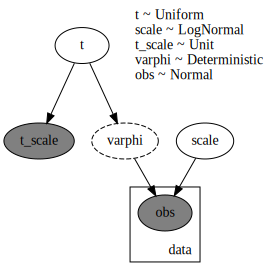

In [ ]:
# run = wandb.Api().run("ddold/subspace_toy_reg/z3h7za53")

# # load params
# params = get_cp_w(run, from_path_optim_sweep=False)

# load samples


def file_fn(c): 
    return f"{c['rng_seed']}_{c['dataset']}_data.npz" if run.sweep.id == 'c3gv5slh' else f"{c['rng_seed']}_data.npz"
    # return f"{c['rng_seed']}_{c['dataset']}_data.npz"
x, y, x_val, y_val, x_test, y_test = get_data(
    run, from_path_optim_sweep=False, get_file_name=file_fn)

samples = get_samples_from_run(run)

model, config, params = get_model_from_run_path(run, from_path_optim_sweep=False)

numpyro.render_model(model, (x,y), render_distributions=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,1.300,1.520,0.058,3.424,0.016,0.011,9381.0,9228.0,1.0
varphi[0],-0.114,0.605,-1.238,1.034,0.006,0.005,9602.0,8699.0,1.0
varphi[1],-0.163,0.580,-1.182,0.932,0.006,0.004,9688.0,8456.0,1.0


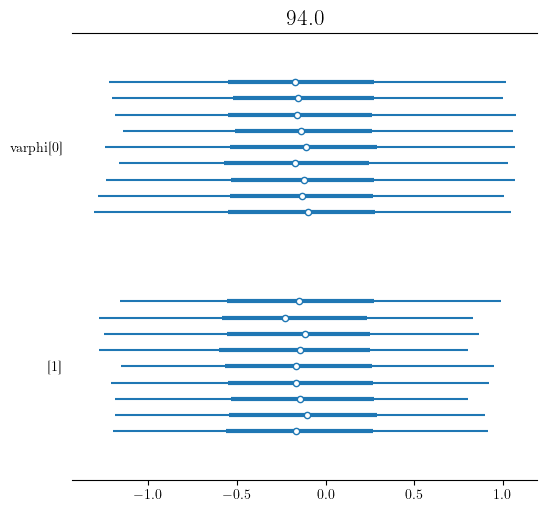

In [ ]:
# Drop chains with NaN samples
num_clean_chains = samples.posterior.dropna(
    dim='chain', how='any').chain.size
clean_samples = az.InferenceData(posterior=samples.posterior.dropna(dim='chain', how='any'),
                                 log_likelihood=samples.log_likelihood.dropna(dim='chain', how='any'))

# clean_samples = samples.posterior.dropna(dim='chain', how='any')
az.plot_forest(clean_samples, var_names='varphi', combined=False)
az.summary(clean_samples)

In [ ]:
summary_var = az.summary(clean_samples)
metrics = dict(
    r_hat_max=summary_var['r_hat'].max(),
    r_hat_mean=summary_var['r_hat'].mean(),
    ess_min=summary_var['ess_bulk'].min(),
    ess_mean=summary_var['ess_bulk'].mean(),
    num_clean_chains=num_clean_chains)
metrics

{'r_hat_max': 1.0,
 'r_hat_mean': 1.0,
 'ess_min': 9381.0,
 'ess_mean': 9557.0,
 'num_clean_chains': 9}

In [ ]:
rng_key = random.PRNGKey(0)
if run.config['sampling']['space_config']['space'] == 'lambda':
    m_post = aZsamples_to_model_samples(clean_samples)
elif run.config['sampling']['space_config']['space'] == 'varphi':
    m_post = aZsamples_to_model_samples_phi(clean_samples)
else:
    raise ValueError("Unknown space")
rng_key, lppd_val, rmse_val = compute_metrics(rng_key, x_val, y_val, model, num_clean_chains, m_post)
rng_key, lppd_test, rmse_test = compute_metrics(rng_key, x_test, y_test, model, num_clean_chains, m_post)

In [ ]:
metrics['elpd_test']=lppd_test.item()
metrics['rmse_test']=rmse_test.item()
metrics['elpd_valid']=lppd_val.item()
metrics['rmse_valid']=rmse_val.item()
metrics

{'r_hat_max': 1.0,
 'r_hat_mean': 1.0,
 'ess_min': 9381.0,
 'ess_mean': 9557.0,
 'num_clean_chains': 9,
 'elpd_test': -0.7977167963981628,
 'rmse_test': 0.10138886421918869,
 'elpd_valid': -0.7175660729408264,
 'rmse_valid': 0.09727860987186432}

In [ ]:
run.tags = ['re_evaluated_with_cleaned_samples']
run.summary.update(metrics)
run.update()

#### run uci correction

In [ ]:
api = wandb.Api()
results = []
for s_id in ['xgfaa57w',]:
    t_bar = tqdm(api.sweep(f"ddold/subspace_uci/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if ((run.state == 'finished') or (run.state == 'crashed')):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config'].get(
                           'prior_scale', -1),
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       Dataset=run.config['dataset'],
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                       #    elpd_loo=run.summary.get('elpd_loo', -np.inf),
                       lppd_test=run.summary.get('elpd_test', np.nan),
                       rmse_test=run.summary.get('rmse_test', np.nan),
                       lppd_valid=run.summary.get('elpd_valid', np.nan),
                       rmse_valid=run.summary.get('rmse_valid', np.nan),
                       #    p_loo=run.summary.get('p_loo', -np.inf),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(
                f"Encoundert problem with run {run.name}; state: {run.state}")

df = pd.DataFrame(results)
df

Sweep id: xgfaa57w:   0%|          | 0/1350 [00:00<?, ?it/s, misunderstood-sweep-1331]

Sweep id: xgfaa57w: 100%|██████████| 1350/1350 [00:03<00:00, 425.95it/s, quiet-sweep-1]          


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,rmse_test,lppd_valid,rmse_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,rxrylxhh,mclmc,varphi,0.5,-1.0,-1,464.159,relu,20,4,...,-2.462827,1.671295,-2.425332,1.356162,15.192266,1.0,1.000,9422.0,10541.70,50
1,qn57qja3,mclmc,varphi,0.5,-1.0,-1,215.443,relu,20,4,...,-2.212892,0.992473,-2.167043,0.848260,11.204081,1.0,1.000,9554.0,10912.85,50
2,em7ny5d3,mclmc,varphi,0.5,-1.0,-1,100.000,relu,20,4,...,-1.850396,0.646221,-1.791107,0.560382,12.958948,1.0,1.000,9207.0,11304.00,50
3,47afjxcn,mclmc,varphi,0.5,-1.0,-1,46.416,relu,20,4,...,-1.424898,0.623584,-1.346073,0.504961,15.273131,1.0,1.000,9521.0,10969.55,50
4,qt56czso,mclmc,varphi,0.5,-1.0,-1,21.544,relu,20,4,...,-0.744725,0.380892,-0.655028,0.297162,12.131696,1.0,1.000,4713.0,8292.75,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,h6s9feq4,mclmc,lambda,0.5,0.1,25,21.544,relu,2,0,...,-0.126987,0.252201,-0.025152,0.235473,221.403774,1.0,1.000,11016.0,11168.50,100
1346,4kqnxm5d,mclmc,lambda,0.5,0.1,25,10.000,relu,2,0,...,-0.146772,0.252254,-0.035744,0.235478,225.182420,1.0,1.000,10650.0,11372.00,100
1347,chuyo489,mclmc,lambda,0.5,0.1,25,4.642,relu,2,0,...,-0.156694,0.252284,-0.041359,0.235521,128.807516,1.0,1.000,11789.0,12058.00,100
1348,6acigcba,mclmc,lambda,0.5,0.1,25,2.154,relu,2,0,...,-0.162440,0.252298,-0.044503,0.235580,118.412023,1.0,1.000,11537.0,11990.00,100


In [ ]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
rerun_ids = df[idx_config_with_nan]['Id'].values
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,rmse_test,lppd_valid,rmse_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
547,fkobqp46,mclmc,varphi,0.5,-1.0,-1,2.154,relu,20,4,...,-0.884945,0.572212,-0.863254,0.553827,44.383830,NaN,NaN,1.0,2.047619,50
571,7mcfj9js,mclmc,varphi,0.5,-1.0,-1,21.544,relu,20,3,...,0.075999,0.231380,0.138423,0.215917,44.319174,NaN,NaN,104.0,655.047619,50
573,pcmz0nhs,mclmc,varphi,0.5,-1.0,-1,2.154,relu,20,3,...,-1.052810,0.699890,-1.023133,0.678395,46.555130,NaN,NaN,1.0,1.571429,50
574,iiocv0ti,mclmc,varphi,0.5,-1.0,-1,1.000,relu,20,3,...,0.023211,0.232306,0.108783,0.216862,112.402513,NaN,NaN,714.0,1041.095238,50
627,mfjmyidz,mclmc,varphi,0.5,-1.0,-1,4.642,relu,20,1,...,-0.581664,0.301359,-0.588940,0.310941,46.352482,NaN,NaN,1.0,1.904762,50
630,30sqackb,mclmc,varphi,0.5,-1.0,-1,1.000,relu,20,1,...,NaN,NaN,NaN,NaN,46.739650,NaN,NaN,NaN,NaN,50
647,fxdpk772,mclmc,lambda,0.5,0.1,25,1.000,relu,20,1,...,0.084364,0.225308,-0.002435,0.244159,437.011557,NaN,NaN,1.0,2.219512,100
653,3otepio1,mclmc,varphi,0.5,-1.0,-1,10.000,relu,20,0,...,-0.131190,0.256715,-0.031609,0.240370,46.802565,NaN,NaN,19.0,321.809524,50
655,kzgtjccy,mclmc,varphi,0.5,-1.0,-1,2.154,relu,20,0,...,NaN,NaN,NaN,NaN,46.905925,NaN,NaN,NaN,NaN,50
672,i3owx3qz,mclmc,lambda,0.5,0.1,25,4.642,relu,20,0,...,-0.105130,0.255229,0.008426,0.235708,356.790039,NaN,NaN,1.0,2.560976,100


In [ ]:
dry_run = False
tqdm_run = tqdm(rerun_ids)
for id in tqdm_run:
    tqdm_run.set_postfix_str(id)
    run = wandb.Api().run(f"ddold/subspace_uci/{id}")

    # load data
    def file_fn(c):
        return f"{c['rng_seed']}_{c['dataset']}_data.npz"

    x, y, x_val, y_val, x_test, y_test = get_data(
        run, from_path_optim_sweep=False, get_file_name=file_fn)
    # load samples
    samples = get_samples_from_run(run)
    # load model
    model, config, params = get_model_from_run_path(
        run, from_path_optim_sweep=False)

    # clean samples and remove chains with nans
    num_clean_chains = samples.posterior.dropna(
        dim='chain', how='any').chain.size
    print(f"Num clean chains: {num_clean_chains}")
    if num_clean_chains == 0:
        print(f"No chains left for run.id: {run.id}\n continue...")
        run.summary.update({'num_clean_chains': 0})
        continue
    if run.config['dataset'] != 'bikesharing':
        clean_samples = az.InferenceData(posterior=samples.posterior.dropna(dim='chain', how='any'),
                                        log_likelihood=samples.log_likelihood.dropna(dim='chain', how='any'))
    else:
        clean_samples = az.InferenceData(posterior=samples.posterior.dropna(dim='chain', how='any'))
    summary_var = az.summary(clean_samples)
    metrics = dict(
        r_hat_max=summary_var['r_hat'].max(),
        r_hat_mean=summary_var['r_hat'].mean(),
        ess_min=summary_var['ess_bulk'].min(),
        ess_mean=summary_var['ess_bulk'].mean(),
        num_clean_chains=num_clean_chains)

    # rerun lppd and rmse
    if run.config['sampling']['space_config']['space'] == 'lambda':
        m_post = aZsamples_to_model_samples(clean_samples)
    elif run.config['sampling']['space_config']['space'] == 'varphi':
        m_post = aZsamples_to_model_samples_phi(clean_samples)
    elif run.config['sampling']['space_config']['space'] == 'line':
        m_post = aZsamples_to_model_samples_line(clean_samples)
    else:
        raise ValueError("Unknown space")

    rng_key = random.PRNGKey(0)
    rng_key, lppd_val, rmse_val = compute_metrics(
        rng_key, x_val, y_val, model, num_clean_chains, m_post)
    rng_key, lppd_test, rmse_test = compute_metrics(
        rng_key, x_test, y_test, model, num_clean_chains, m_post)

    # add metrics to the summary
    metrics['elpd_test'] = lppd_test.item()
    metrics['rmse_test'] = rmse_test.item()
    metrics['elpd_valid'] = lppd_val.item()
    metrics['rmse_valid'] = rmse_val.item()

    # update metrics
    if dry_run:
        print("Would update:")
        print(metrics)
    else:
        run.tags = ['re_evaluated_with_cleaned_samples']
        run.summary.update(metrics)
        run.update()